# Capstone Project

## Executive Summary

Having scraped four distinct categories worth of reviews from Amazon, I intended to build a model that would be able to predict the utility of a product review as left by a customer for products within that category.

I have defined a review as having utility when it has been marked as 'helpful' by other Amazon customers
<div style="width:500px; margin-top:25px;">
<img src = './attachments/Screen%20Shot%202018-05-26%20at%2010.56.52.png'>
</div>

I don't want to predict _how_ useful a comment may be, only that it is considered helpful by other shoppers.

After having scraped reviews from the following Categories in Amazon:

1. Digital SLR Cameras
2. Beers, Wines & Spirits
2. Playmobil
3. Men's Shoes


I was able to look at how the classiifcations were broken down:

<div style = "width:800px; align:center;">
<img src = './attachments/grouped_helpful.png'>
</div>

It was initially clear that there was some class imbalance, and when there is great class imbalance, it can be much harder to train a model to achieve an accuracy over the proportion of the most prominent class, but not impossible!

The biggest risk I have discovered with the Exploratory Data Analysis (EDA) is that reviews can be objectively useful, but that if noone has hit the button to mark a review as helpful, it will look in my dataset as unhelpful.

## Goal & Metrics

My Goal is to build a model that is able to accurately identify whether a review would be considered as helpful by other users. In theory this could be used at the point of a user submitting a review to better index reviews on the product's review page

When Classifying a dependent variable, the key measures to look at are: Accuracy, Precision and Recall. When looking at imbalanced datasets, the ROC Curve and the Precision Recall Curves will allow us to see how well our model is classifying, because they are not affected by the imbalance of the classes. I shall for this be focussing on the Area Under the ROC curve (AUC) as this will indicate the probability that with a given model, it will rank a randomly chosen positive value higher than a randomly chosen negative example.


# The Models


## Initial modelling.

I initially looked at the dataset as a whole, and made the decision to build models naive of category. I made this decision on the basis of:

1. A useful review is a useful review regardless of the product category.
2. A single naive model could be preferable in a production environment.

I have started with the full corpus of reviews scraped, because I'm starting with the assumption that useful reviews will share similar characteristics across the whole of Amazon, and because it would be preferable to have one model across a site that could predict the utility of a comment left by customers. Fewer models means fewer things to go wrong, and fewer things to keep updated.

## LDA Modelling

### Introduction

I want to use LDA (Latent Dirichlet Allocation) to look at the topics contained within the reviews left by customers to establish if it is possible to predict the category that the review is taken form, my thought being this if the topic/category can be predicted, then the comment stands a greater chance of being seen as useful rather than being a general comment about delivery or something else entirely.

In doing this, I will establish if there is any relationship between a comment belonging to an identified topic, and whether membership of that topic increases the probability that the review is considered useful.

My initial hypothesis is that there will be 5 identifiable topics from the reviews - one per product category, and a general topic relating to delivery or service.

In [170]:
# Imports & Set Up

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
from pprint import pprint
import scipy.stats as ss

from gensim import corpora, models, matutils
from gensim.matutils import Sparse2Corpus

from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from collections import defaultdict

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
nltk_stops = stopwords.words()
from nltk.stem.wordnet import WordNetLemmatizer
import string

import pyLDAvis
import pyLDAvis.sklearn

plt.style.use('fivethirtyeight')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import warnings
warnings.filterwarnings('ignore')

# some defualt colours
colours = ["#69F0AE", "#FFC070", "#8b69f0", "#70BCED", "#f069ce", "#eef069", '#ff5252', '#448aff',
        '#ffab40', '#536dfe', '#ff8a65', '#80cbc4', '#f06292', '#689F38', '#546E7A', '#0091EA']
dark_green = "#3D996C"

[nltk_data] Downloading package stopwords to /Users/Tim/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [7]:
# Model Imports
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier, BaggingClassifier
from sklearn.model_selection import cross_val_score, train_test_split, cross_val_predict, GridSearchCV
from sklearn.pipeline import Pipeline, FeatureUnion


# Metric Imports
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score, accuracy_score, confusion_matrix, classification_report

In [ ]:
#Load in the Scraped Data
play = pd.read_csv('./attachments/playmobil_reviews3.csv')
play.drop('Unnamed: 0', axis=1, inplace=True)
play.stars = play.stars.astype(int)
play.author = play.author.map(lambda x: x.split("/")[0])
play.date = pd.to_datetime(play.date, format='%d %B %Y')

bws = pd.read_csv('./attachments/bws_reviews.csv')
bws.drop('Unnamed: 0', axis=1, inplace=True)
bws.stars = bws.stars.astype(int)
bws.author = bws.author.map(lambda x: x.split("/")[0])
bws.date = pd.to_datetime(bws.date, format='%d %B %Y')

shoe = pd.read_csv('./attachments/amazon_shoe_reviews.csv')
shoe.drop('Unnamed: 0', axis=1, inplace=True)
shoe.stars = shoe.stars.astype(int)
shoe.author = shoe.author.map(lambda x: x.split("/")[0])
shoe.date = pd.to_datetime(shoe.date, format='%d %B %Y')

slr = pd.read_csv('./attachments/slr_reviews.csv')
slr.drop('Unnamed: 0', axis=1, inplace=True)
slr.stars = slr.stars.astype(int)
slr.author = slr.author.map(lambda x: x.split("/")[0])
slr.date = pd.to_datetime(slr.date, format='%d %B %Y')

#Set a topic column, so I can identify which category a review came from
play['category'] = "playmobil"
bws['category'] = "bws"
shoe['category'] = "shoes"
slr['category'] = "slr"

play['topic'] = 3
bws['topic'] = 2
shoe['topic'] = 1
slr['topic'] = 0

#merge the Data to one dataframe
df = pd.concat([slr, shoe, bws, play])

#Set a 'Useful' column, shows 1 when at least 1 person has found the review helpful
#need to fix the fact that pandas treats most elements as int, but one as a string
df.helpful = df.helpful.astype(str)
df.helpful = df.helpful.map(lambda x: x.replace(",", ""))
df.helpful = df.helpful.astype(int)
df['useful'] = df.helpful.map(lambda x: 1 if x > 0 else 0)

#remove any duplicate reviews
df = df.drop_duplicates()

#reset the index, gives each row a unique identifier
df.reset_index(inplace=True, drop=True)

### Cleaning the Review Text


In [6]:
#Custom function to clean the review text
stop = set(stopwords.words('english'))
exclude = set(string.punctuation)
lemma = WordNetLemmatizer()


def clean(doc):
    """Returns a list of lists, each being a list of cleaned words from each review"""

    stop_free = " ".join([i for i in doc.lower().split() if i not in stop])
    punc_free = ''.join(ch for ch in stop_free if ch not in exclude)
    normalized = " ".join(lemma.lemmatize(word) for word in punc_free.split())
    return normalized


doc_clean = [clean(doc) for doc in df.comment]

In [7]:
# Run a test to check that I get wat was expected
doc_clean[0:5]

['bought replace ageing model really tell difference year model model smaller lighter take better picture extra feature quality picture really fantastic price think struggle find better worth noting well taking great quality picture also let record video 720p good quality stuttering footage colour natural pleasant eye round good camera also get taken little day trip',
 'really like digital camera quality super niceits designed give nontechnical user easy way get started camera packed sturdy paper boxthe concept feature great simple structure convenient use time people outgoing adjustable strap convenience able use door good digital camera deserve price',
 'camera work well memory card it something bought time unsure camera robustness time tell everything seems relatively easy use well instruction manual supplied two language cantonese or possibly mandarin odd form english take deciphering',
 'everything seems okhavent used lot hence 4stars',
 'fantastic picture quality performancei lov

### Count Vectorising the Reviews

In [8]:
# Create a count vectorised Matrix of the 10000 most common 1,2 and 3 word phrases used in the dataset
cvec = CountVectorizer(
    stop_words='english', 
    max_features=10000, 
    ngram_range=(1, 3))
cmat = cvec.fit_transform(doc_clean)

### Fitting the LDA model on the Reviews - Top Words by Topic

In [9]:
# Apply LDA to the count vectorised matrix, set LDA to discover 5 topics
lda = LatentDirichletAllocation(n_components=5, 
                                max_iter=20, 
                                learning_method='online', 
                                learning_offset=50.,
                                random_state=0)

model = lda.fit_transform(cmat)

In [10]:
#function to display the top n words in an identified topic
def display_topics(model, feature_names, no_top_words):
    # cycle through identified tpics
    for topic_idx, topic in enumerate(lda.components_):
        print("Topic %d:" % (topic_idx))
        #print the top words per topic as a comma separated string
        print(", ".join([
            feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]
        ]))
        print("\n")

Having a look at the result of the first 5 topics discovered by LDA:

In [11]:
#display the top 50 words for each of the identified topics
feature_names = cvec.get_feature_names()
no_top_words = 50
display_topics(lda, feature_names, no_top_words)

Topic 0:
taste, like, bottle, drink, gin, whisky, best, smooth, flavour, rum, really, vodka, wine, tried, buy, delicious, sweet, favourite, good, try, whiskey, malt, ive, ice, make, im, say, worth, glass, tasted, better, tasting, bourbon, cocktail, drinking, definitely, great, beer, tonic, quite, enjoyed, different, single, strong, expensive, bit, enjoy, wonderful, single malt, drinker


Topic 1:
camera, use, shoe, lens, good, size, like, quality, fit, canon, bought, picture, im, really, easy, comfortable, used, running, nikon, work, ive, time, better, photo, review, need, dslr, feel, box, pair, problem, ok, using, buy, new, fine, kit, best, image, half, granddaughter, red, happy, photography, far, say, video, feature, look, easy use


Topic 2:
great, good, price, excellent, product, delivery, quality, arrived, item, time, service, expected, wine, fast, good price, perfect, quick, good quality, great price, quickly, delivered, thanks, great product, fantastic, worth, described, deal, d

It is pretty clear that the topics I was expecting overlap somewhat. The top 30 words per topic can be seen in the below visualisation

In [12]:
pyLDAvis.enable_notebook()
panel = pyLDAvis.sklearn.prepare(lda, cmat, cvec, mds='tsne')
panel

PreparedData(topic_coordinates=            Freq  cluster  topics          x          y
topic                                                  
1      30.360363        1       1  -0.859396  64.683708
0      23.655473        1       2   5.930807   7.048829
4      19.900373        1       3 -51.702892   0.258554
3      14.100270        1       4  63.566071  13.839053
2      11.983521        1       5  12.721495 -50.585701, topic_info=     Category          Freq               Term         Total  loglift  logprob
term                                                                          
5411  Default  17200.000000               love  17200.000000  30.0000  30.0000
4060  Default  29859.000000              great  29859.000000  29.0000  29.0000
3782  Default  29241.000000               good  29241.000000  28.0000  28.0000
6915  Default  12865.000000              price  12865.000000  27.0000  27.0000
1442  Default  20518.000000             camera  20518.000000  26.0000  26.0000
2945  Default  11376.000000          excellent  11376.000000  25.0000  25.0000
7027  Default   9934.000000            product   9934.000000  24.0000  24.0000
6022  Default  11225.000000               nice  11225.000000  23.0000  23.0000
3599  Default   9420.000000               gift   9420.000000  22.0000  22.0000
8785  Default  11897.000000              taste  11897.000000  21.0000  21.0000
5525  Default   8489.000000             lovely   8489.000000  20.0000  20.0000
1086  Default  15475.000000             bought  15475.000000  19.0000  19.0000
9916  Default   9543.000000               year   9543.000000  18.0000  18.0000
6834  Default   7756.000000            present   7756.000000  17.0000  17.0000
2412  Default   6363.000000           delivery   6363.000000  16.0000  16.0000
7183  Default  10699.000000            quality  10699.000000  15.0000  15.0000
6669  Default   7376.000000          playmobil   7376.000000  14.0000  14.0000
6219  Default   7012.000000                old   7012.000000  13.0000  13.0000
540   Default   5225.000000            arrived   5225.000000  12.0000  12.0000
5130  Default  13746.000000               like  13746.000000  11.0000  11.0000
1019  Default  10730.000000             bottle  10730.000000  10.0000  10.0000
5499  Default   6308.000000              loved   6308.000000   9.0000   9.0000
2629  Default   8863.000000              drink   8863.000000   8.0000   8.0000
1816  Default   6019.000000          christmas   6019.000000   7.0000   7.0000
4790  Default   4295.000000               item   4295.000000   6.0000   6.0000
8359  Default   4578.000000                son   4578.000000   5.0000   5.0000
9433  Default   5488.000000              value   5488.000000   4.0000   4.0000
9129  Default   5322.000000                toy   5322.000000   3.0000   3.0000
8279  Default   5954.000000             smooth   5954.000000   2.0000   2.0000
3674  Default   8257.000000                gin   8257.000000   1.0000   1.0000
...       ...           ...                ...           ...      ...      ...
4186   Topic5   1767.670338      great product   1768.506522   2.1212  -4.8922
2457   Topic5   1473.745924          described   1474.586617   2.1211  -5.0740
2314   Topic5   1414.712960               deal   1415.559902   2.1210  -5.1149
2391   Topic5   1412.997312          delighted   1413.856995   2.1210  -5.1161
7252   Topic5   1140.554884     quick delivery   1141.390947   2.1209  -5.3303
3025   Topic5   2670.092934           expected   2672.077132   2.1209  -4.4797
2976   Topic5    911.620697  excellent product    912.456628   2.1207  -5.5544
574    Topic5    863.835941       arrived time    864.673266   2.1207  -5.6082
3884   Topic5    849.938470       good product    850.774126   2.1207  -5.6244
566    Topic5    775.482611    arrived quickly    776.320602   2.1206  -5.7161
4195   Topic5    747.513130      great quality    748.358654   2.1205  -5.7528
7108   Topic5    712.775541           promptly    713.616235   2.1205  -5.8004
1860   Top

### Looking at the Dominant Topic in Each Comment

In [40]:
# Create Document - Topic Matrix
lda_output = lda.transform(cmat)

# column names
topicnames = ["Topic" + str(i) for i in range(lda.n_components)]

# index names
docnames = ["Doc" + str(i) for i in range(len(df.comment))]

# Make the dataframe
df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topicnames)

# Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominant_topic'] = dominant_topic


# Styling
def color_green(val):
    color = 'green' if val > .1 else 'black'
    return 'color: {col}'.format(col=color)


def make_bold(val):
    weight = 700 if val > .1 else 400
    return 'font-weight: {weight}'.format(weight=weight)


#Add the original topics
df_document_topic['original_topic'] = df.topic

# Apply Style (Displays top 10 rows of reviews only for demonstration)
df_document_topics = df_document_topic.head(10).style.applymap(
    color_green).applymap(make_bold)
df_document_topics

,Topic0,Topic1,Topic2,Topic3,Topic4,dominant_topic,original_topic
0,0.05,0.62,0.17,0,0.16,1,0
1,0,0.78,0.1,0,0.11,1,0
2,0.01,0.81,0.05,0.06,0.08,1,0
3,0.05,0.8,0.05,0.05,0.05,1,0
4,0.01,0.79,0.09,0.1,0.01,1,0
5,0.01,0.58,0.27,0.06,0.08,1,0
6,0.1,0.1,0.6,0.1,0.1,2,0
7,0.01,0.73,0.08,0.17,0.01,1,0
8,0.01,0.95,0.01,0.01,0.01,1,0
9,0.49,0.43,0.07,0.01,0.01,0,0


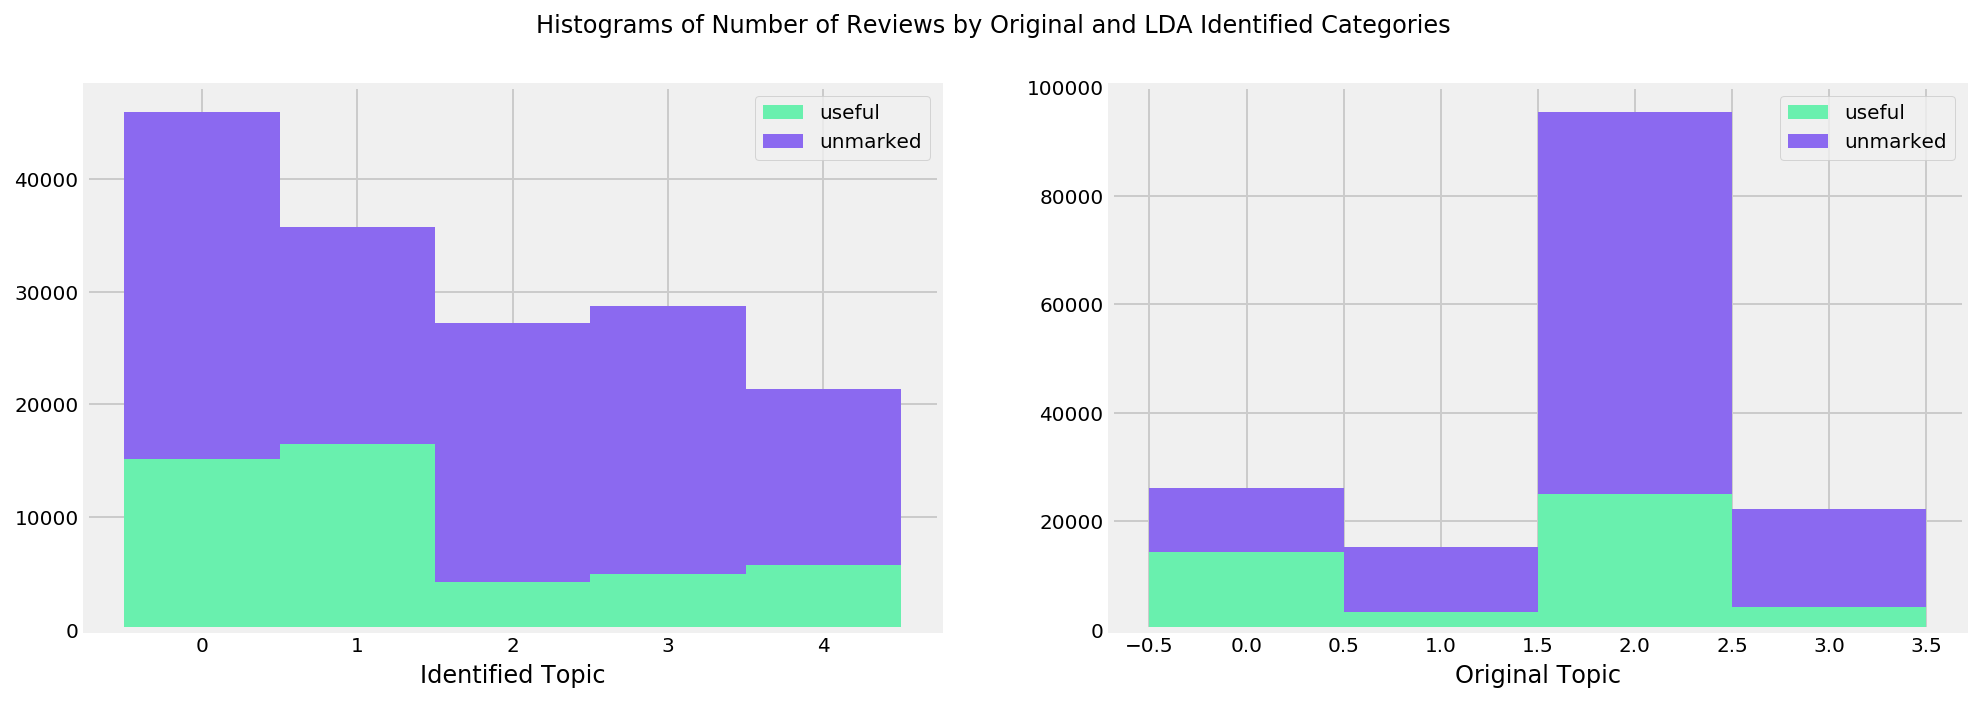

In [75]:
#generate 2 graphs, on showing utitlity broken down by dicovered topics, one by known categories
fig, axes = plt.subplots(figsize=(15, 5), nrows=1, ncols=2)
ax0, ax1 = axes.flatten()
ax0.hist(
    [
        df_document_topic.dominant_topic[df.useful == 1],
        [df_document_topic.dominant_topic[df.useful == 0]]
    ],
    bins=[0, 1, 2, 3, 4, 5],
    histtype='bar',
    stacked=True,
    align='left',
    label=['useful', 'unmarked'],
    color=["#69F0AE", "#8b69f0"])

ax1.hist(
    [
        df_document_topic.original_topic[df.useful == 1],
        [df_document_topic.original_topic[df.useful == 0]]
    ],
    bins=[0, 1, 2, 3, 4],
    histtype='bar',
    stacked=True,
    align='left',
    label=['useful', 'unmarked'],
    color=["#69F0AE", "#8b69f0"])
ax0.legend()
ax1.legend()
ax0.set_ylabel = 'No. Reviews'
ax0.set_xlabel('Identified Topic')
ax1.set_xlabel('Original Topic')
ax1.set_ylabel = 'No. Reviews'
fig.suptitle(
    "Histograms of Number of Reviews by Original and LDA Identified Categories"
)
plt.show()

After many (many) attempts at appllying LDA to mirror the predefined topics, I discovered that it was unlikely my current method would be fruitful. It was nevertheless interesting to look at the identification of topics within the full corpus of reviews, I was surprised to see that gifts seemed to dominate an entire topic (topic 4). It is clear that both Beer Wines & Spirits and Playmobil are frequently given as gifts, hopefully to separate recipients.

## Sentiment Analysis on Product Reviews

I then decided to look at the sentiment contained in each review to establish if there was any predicitive capacity for utility.
  
I used the VADER (Valence Aware Dictionary and sEntiment Reasoner) library to parse each review and establish 4 scores per review: The scores are ratios for proportions of text that fall in each category

1. Positivity
2. Neutrality
3. Negativity
4. Compound Score: a normalized, weighted composite score of positivity and negativity between -1 for extremely negative, and 1 for extremely positive

I want to see if there is any predictive capacity in the sentiment discovered as to a comment's utility

In [71]:
#import Vader
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

In [72]:
# iterate through the dataframe and add the scores as new columns
analyzer = SentimentIntensityAnalyzer()
scores = []
for i in range(0,len(df)):

    try:
        vs = analyzer.polarity_scores(df.comment[i])       
        df.loc[i,'comment_neg'] = vs['neg']
        df.loc[i,'comment_neu'] = vs['neu']
        df.loc[i,'comment_pos'] = vs['pos']
        df.loc[i,'comment_compound'] = vs['compound']
    except:
        df.loc[i,'comment_neg'] = 0
        df.loc[i,'comment_neu'] = 0
        df.loc[i,'comment_pos'] = 0
        df.loc[i,'comment_compound'] = 0

Looking at 5 negative reviews

In [8]:
df.comment[df.comment_neg == df.comment_neg.max()].head()

SyntaxError: invalid syntax (<ipython-input-8-ad39c5ce3381>, line 1)

Looking at 5 Positive Reviews

In [50]:
df.comment[df.comment_pos == df.comment_pos.max()].head()

6           good
152         Good
231         Good
385    Excellent
386          aok
Name: comment, dtype: object

Looking at 5 Neutral Reviews

In [56]:
df.comment[df.comment_neu == df.comment_neu.max()].head()

3     Everything seems ok,haven't used it a lot henc...
14                     Product is exactly as described.
27    Really simple to use and set up on my Nikon D3...
40    Range and direction can be a bit pernickity, b...
47           Does the job and much cheaper than Nikon's
Name: comment, dtype: object

#### Fitting a Logistic Regression on Sentiment

In [76]:
lr = LogisticRegression()

In [81]:
#Scale the part of Speech elements 
ss = StandardScaler()
X_ss = ss.fit_transform(df[['comment_pos','comment_neg','comment_neu']])

#set up a train test split
Xtrain,Xtest,ytrain,ytest = train_test_split(X_ss,df['useful'])

In [84]:
#fit a model on the training data
lr_model = lr.fit(Xtrain,ytrain)

In [85]:
#cross validate the model against a test set of data
scores = cross_val_score(lr_model,Xtest,ytest,cv=5)

In [87]:
#print the results of the Cross Validation
print("Scores from each Cross Validation:",scores)
print("Mean Model Accuracy",np.mean(scores))
print("Baseline:",1 - np.mean(ytest))

Scores from each Cross Validation: [0.70715453 0.70715453 0.70724346 0.70720664 0.70720664]
Mean Model Accuracy 0.7071931615748388
Baseline: 0.7071931589537224


Looking at the results of cross validation, it is clear that our model is performing at exactly the baseline - no better than just predicting the review is not useful

#### Confusion Matrix

In [90]:
pd.DataFrame(confusion_matrix(ytest,lr_model.predict(Xtest),labels=[0,1],))

,0,1
0,28118,0
1,11642,0


In fact looking at the confusion matrix for this model, the model is indeed just predicting that every review is not useful 

## Trying Part of Speech Analysis

Using the SPACY module to identiff the parts of speech contained within each review.

In [159]:
#import the spacy library and use the english language parser
import spacy
en_nlp = spacy.load('en')

In [160]:
# Parse each Review using the Spacy library
parsed_quotes = []
for i, parsed in enumerate(en_nlp.pipe(df.comment.values, batch_size=50, n_threads=10)):
    assert parsed.is_parsed
    parsed_quotes.append(parsed)

In [161]:
#identify the unique parts of speech
unique_pos = []
for parsed in parsed_quotes:
    unique_pos.extend([t.pos_ for t in parsed])
unique_pos = np.unique(unique_pos)

In [162]:
#create a column in df for each part of speech
for pos in unique_pos:
    df[pos+'_prop'] = 0.

In [163]:
# add the breakdown of each part of speech in the comment to the df
for i, parsed in enumerate(parsed_quotes):
    parsed_len = len(parsed)
    for pos in unique_pos:
        if parsed_len > 0:
            count = len([x for x in parsed if x.pos_ == pos])
            df.loc[i, pos+'_prop'] = float(count)/parsed_len

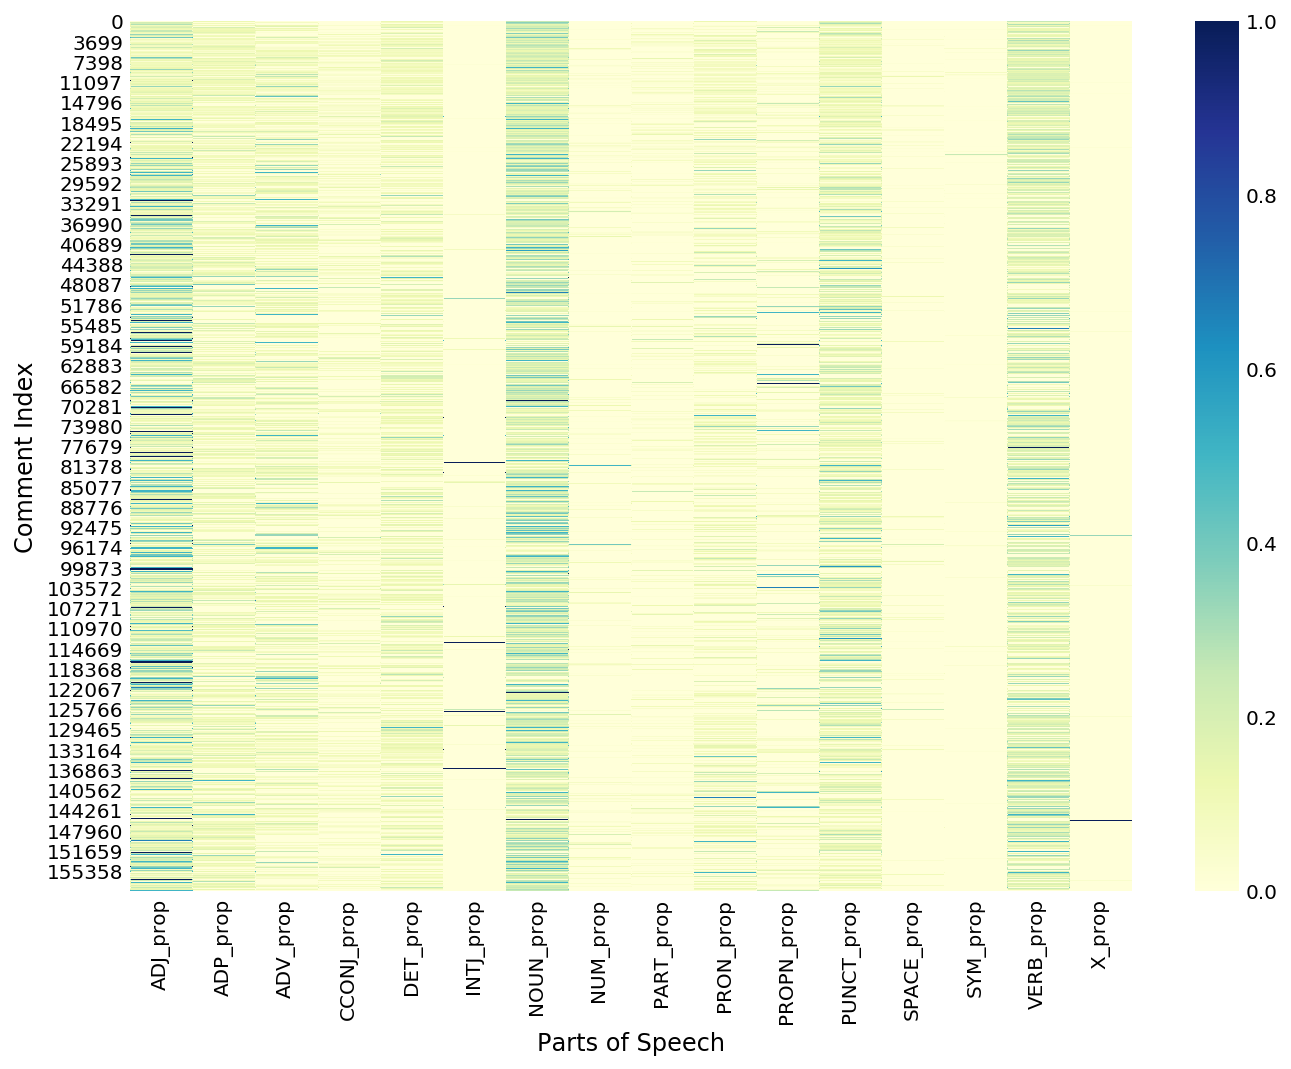

In [70]:
# show a heatmap thet will display each part of speech as a proportion of each review
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(df[[pos+'_prop' for pos in unique_pos]],cmap="YlGnBu")
ax.set_xlabel("Parts of Speech")
ax.set_ylabel("Comment Index")

plt.show()

#### Parts of Speech as a features in a predictive model


In [72]:
# Create aa Train Test Split
Xtrain, Xtest, ytrain, ytest = train_test_split(
    df[[pos+'_prop' for pos in unique_pos]], df.useful)

In [73]:
#Use Logistic Regression as our first model to test
lr = LogisticRegression()
model = lr.fit(Xtrain,ytrain)

In [74]:
scores = cross_val_score(model, Xtest, ytest, cv=5)
print("scores accross all tests:", scores)
print("Average Test Score:", np.mean(scores))
print("Baseline Accuracy: ", 1 - np.mean(ytest))

scores accross all tests: [0.70375959 0.70350811 0.70347082 0.70318199 0.704817  ]
Average Test Score: 0.7037475033022161
Baseline Accuracy:  0.7078219315895372


#### Confusion Matrix

In [75]:
pd.DataFrame(confusion_matrix(ytest,model.predict(Xtest),labels=[0,1],))

,0,1
0,27842,301
1,11529,88


Looking at the confision matrix here, there are only 96 reviews where the model has correctly predicted that a review is considered helpful, that is 96 better than the sentiment analysis model would predict, but still not a good model. 

#### Classification Report

In [76]:
print(classification_report(ytest,lr.predict(Xtest)))

             precision    recall  f1-score   support

          0       0.71      0.99      0.82     28143
          1       0.23      0.01      0.01     11617

avg / total       0.57      0.70      0.59     39760



The recall for a useful review is at 1%. Recall is True Positives over True Positives + False Negatives; The number of False Negatives is so high in this case (11542) that it dwarfs the correctly predicted useful number.

#### ROC Curve

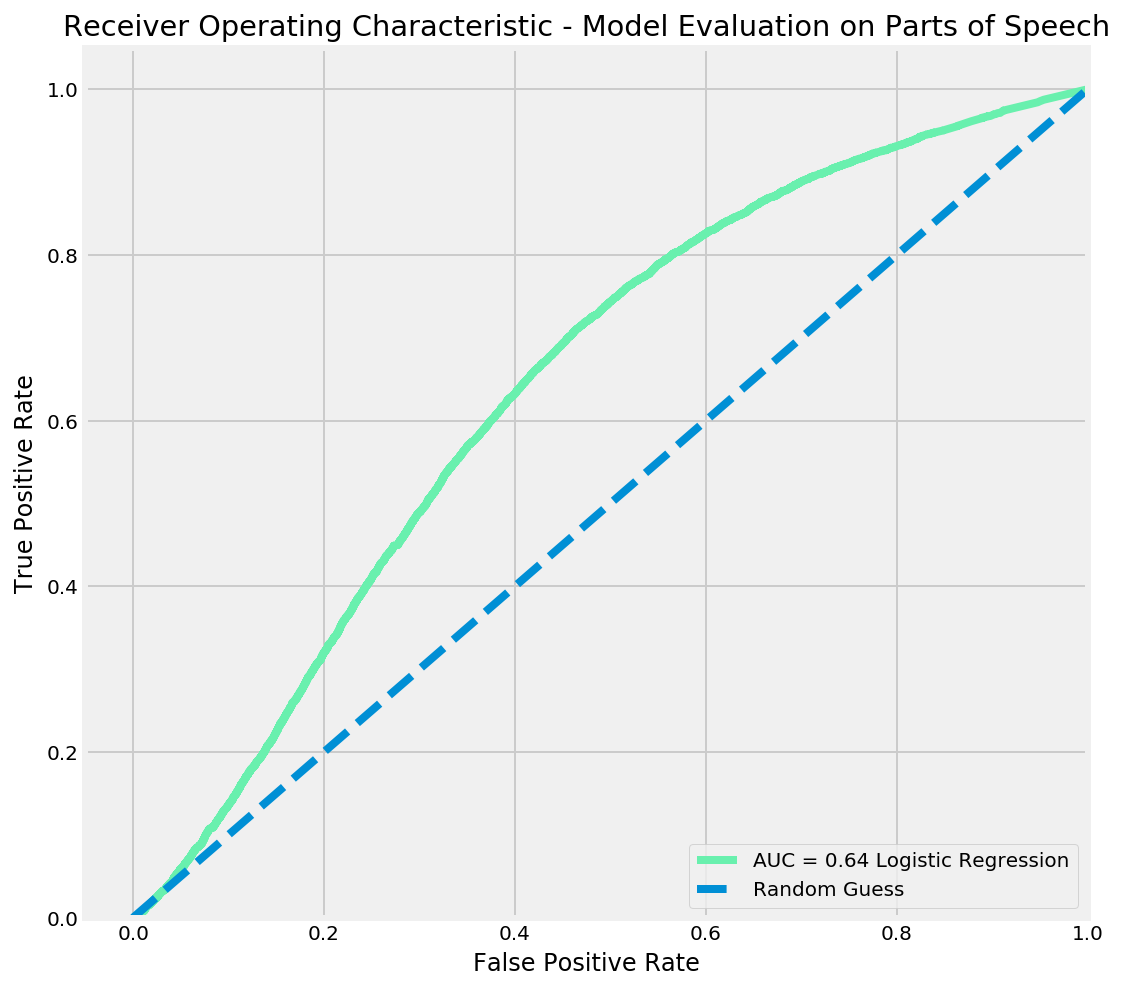

In [77]:
#Plot an ROC curve for each model on the same plot
fig, ax = plt.subplots(figsize=(8, 8))

plt.title(
    'Receiver Operating Characteristic - Model Evaluation on Parts of Speech'
)

probs = lr.predict_proba(Xtest)
preds = probs[:, 1]
fpr, tpr, threshold = roc_curve(ytest, preds)
roc_auc = auc(fpr, tpr)
plt.plot(
    fpr,
    tpr,
    color=colours[0],
    label='AUC = %0.2f' % roc_auc + " " + model_names[0])

plt.plot([0, 1], [0, 1], '--', label="Random Guess")
plt.legend(loc='lower right')

plt.xlim([-0.05, 1.])

plt.ylim([0, 1.05])
ax.set_ylabel('True Positive Rate')
ax.set_xlabel('False Positive Rate')
plt.show()

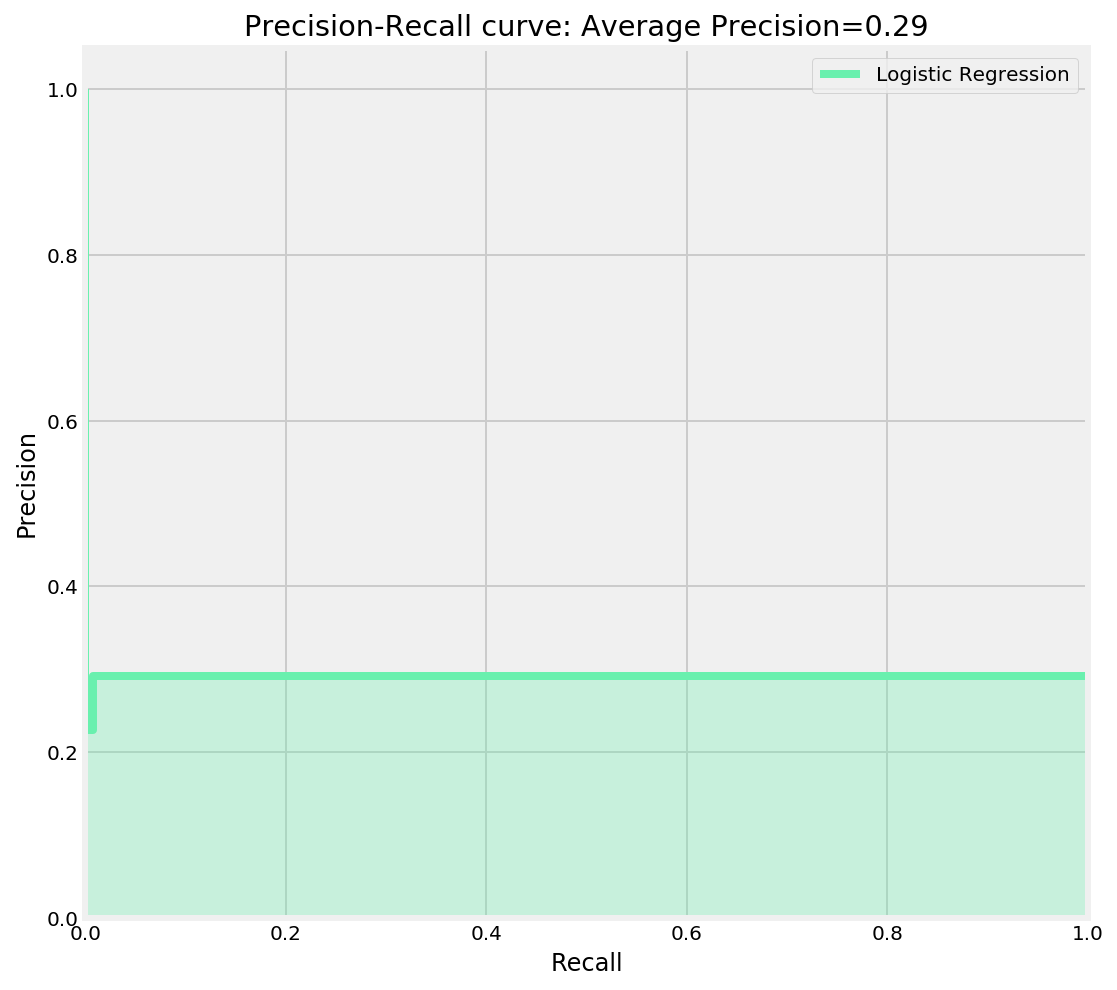

In [79]:
fig, ax = plt.subplots(figsize=(8, 8))

precisions = []
y_score = lr.predict(Xtest)
precision, recall, _ = precision_recall_curve(ytest, y_score)

average_precision = average_precision_score(ytest, y_score)
precisions.append(average_precision)

plt.step(
    recall,
    precision,
    color=colours[0],
    alpha=1,
    where='post',
    label="Logistic Regression")
plt.fill_between(
    recall, precision, step='post', alpha=0.3, color=colours[0])

ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.legend(loc='bottom left')

plt.title('Precision-Recall curve: Average Precision={0:0.2f}'.format(
    np.mean(precisions)))
plt.show()

# Separation

Given that I had found little predictive signal in the reviews as an entire corpus, I decided to reasses my initial decision, and then began to look at establishing four models, one per category.

I had looked at the breakdown of 'useful' reviews by category above, and ventured into where i believed the best model could be fit first - with the Digital SLR Cameras

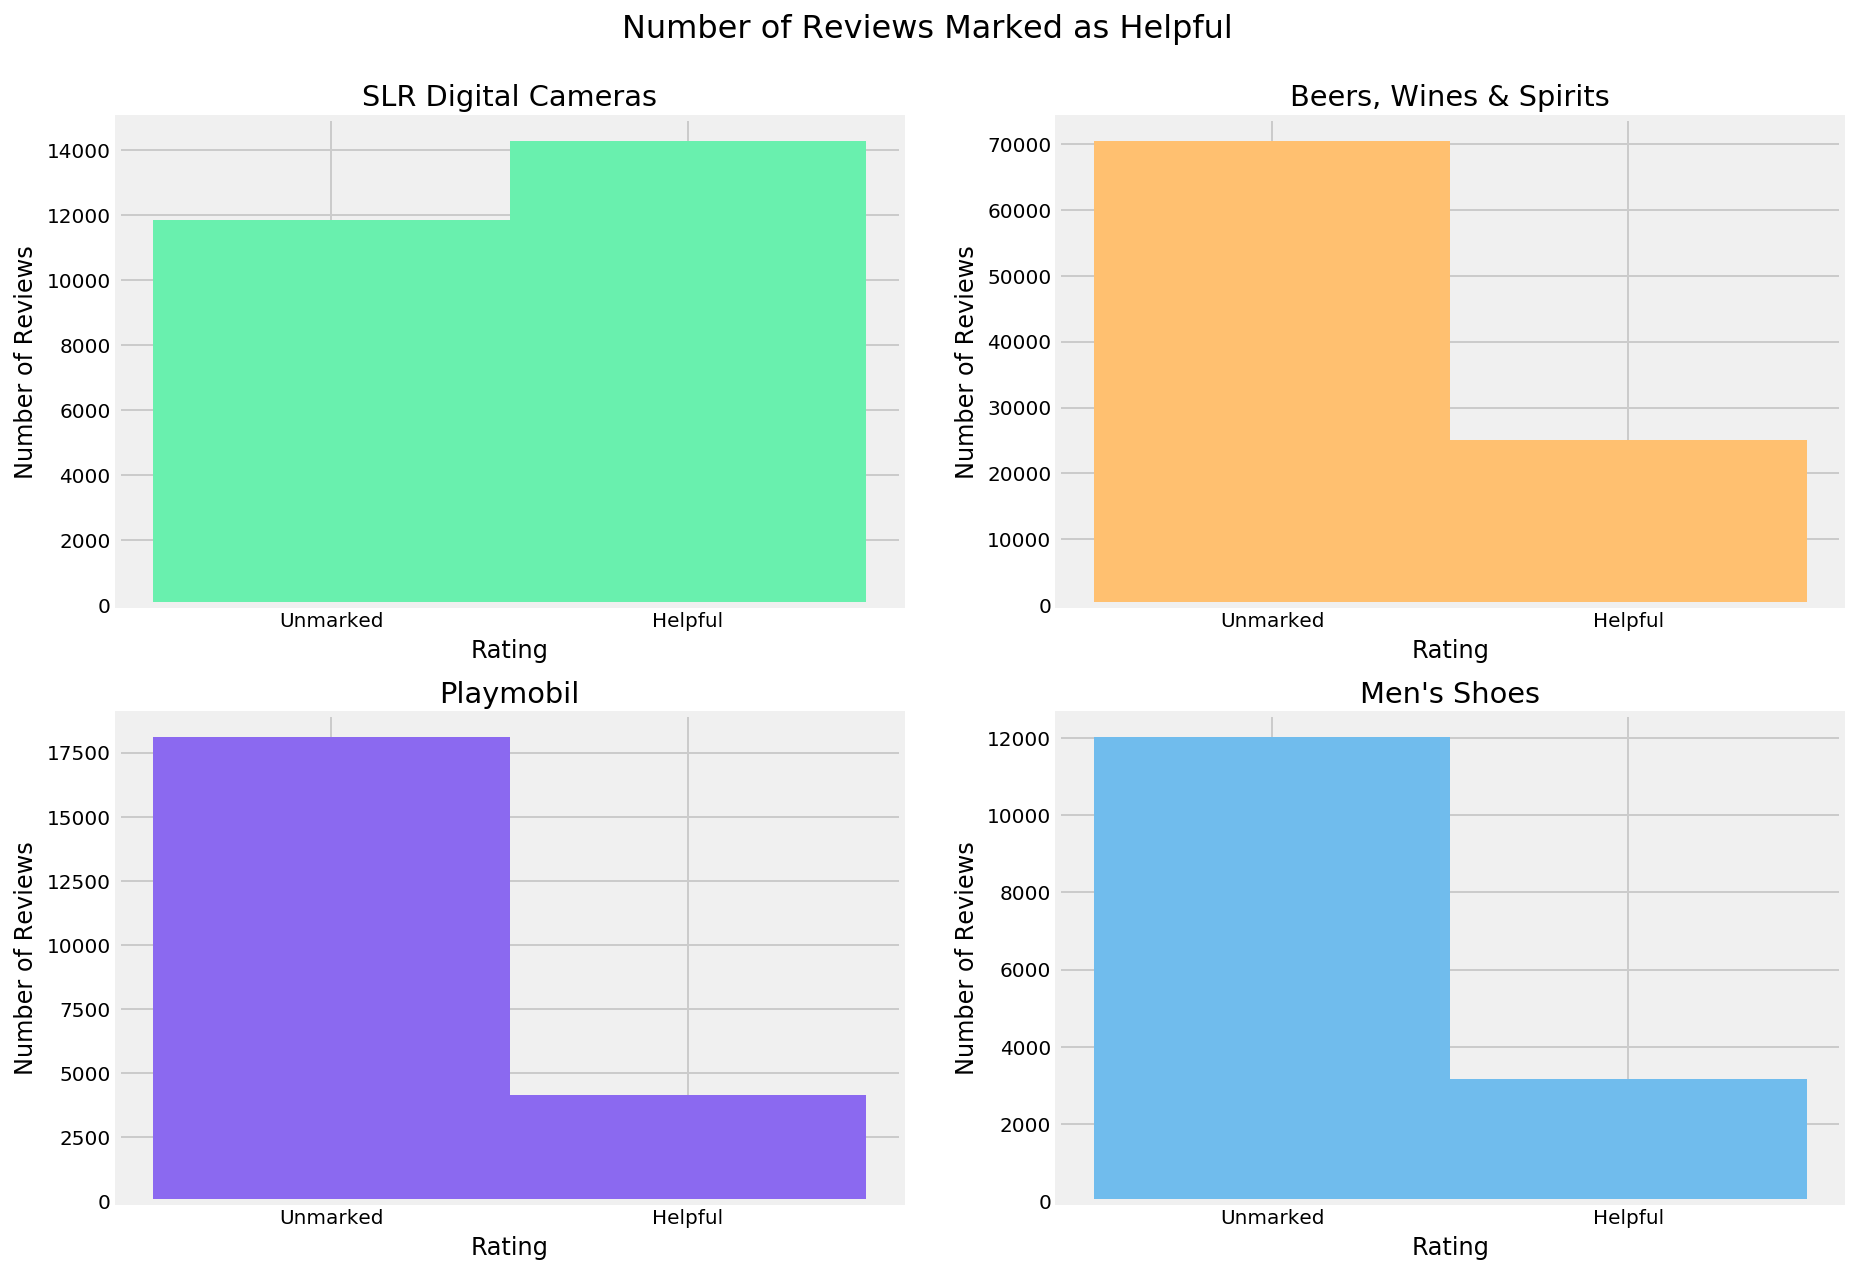

In [93]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(13, 9))
ax0, ax1, ax2, ax3 = axes.flatten()
#set the figure title
plt.suptitle('Number of Reviews Marked as Helpful', fontsize=16)

#Draw 4 Histograms, one per category
df.useful[df.category == "slr"].hist(
    bins=[0, 1, 2], color="#69F0AE", ax=ax0, align='left')
df.useful[df.category == "bws"].hist(
    bins=[0, 1, 2], color="#FFC070", ax=ax1, align='left')
df.useful[df.category == "playmobil"].hist(
    bins=[0, 1, 2], color="#8b69f0", ax=ax2, align='left')
df.useful[df.category == "shoes"].hist(
    bins=[0, 1, 2], color="#70BCED", ax=ax3, align='left')


#Set the subtitles for each histogram
ax0.set_title("SLR Digital Cameras")
ax1.set_title("Beers, Wines & Spirits")
ax2.set_title("Playmobil")
ax3.set_title("Men's Shoes")

#set the axes titles and labels
ax0.set_xlabel("Rating")
ax1.set_xlabel("Rating")
ax2.set_xlabel("Rating")
ax3.set_xlabel("Rating")
ax0.set_ylabel("Number of Reviews")
ax1.set_ylabel("Number of Reviews")
ax2.set_ylabel("Number of Reviews")
ax3.set_ylabel("Number of Reviews")

ax0.set_xticks([0, 1])
ax0.set_xticklabels(['Unmarked', 'Helpful'],)
ax1.set_xticks([0, 1])
ax1.set_xticklabels(['Unmarked', 'Helpful'],)
ax2.set_xticks([0, 1])
ax2.set_xticklabels(['Unmarked', 'Helpful'],)
ax3.set_xticks([0, 1])
ax3.set_xticklabels(['Unmarked', 'Helpful'],)

fig.tight_layout()
plt.subplots_adjust(wspace=0.2, top=0.9)

plt.show()

SLR Digital Cameras has the most evenly balanced class separation between useful and unmarked

# Digital SLR Cameras

Now that I was fitting a model for each category, my goal was to establish the least complex model I could for each category - on the basis that running many models at once in a production environment could be computationally expensive for such a task.

## Count Vectorised Bag of Words

For this model, I used a count vectorisation technique to establish a matrix of the counts of the 5000 most frequently used 1,2 and 3 word phrases within the reviews.

In [10]:
cv = CountVectorizer(ngram_range=(1,3), max_features=5000, binary=True, stop_words='english')
words = cv.fit_transform(df.comment[df.category == "slr"])

In [11]:
words = pd.DataFrame(words.todense(), columns=cv.get_feature_names())

In [12]:
Xtrain, Xtest, ytrain, ytest = train_test_split(
    words.values,
    df.useful[df.category == "slr"].values,
    test_size=0.25,
    stratify=df.useful[df.category == "slr"].values)

In [13]:
# Use an array of classifying algorithms to establis the best out of the box estimator
models = [
    LogisticRegression(),
    DecisionTreeClassifier(max_depth=10),
    RandomForestClassifier(),
    ExtraTreesClassifier(),
    BaggingClassifier(),
    AdaBoostClassifier(),
    BernoulliNB()
]

In [14]:
model_names = [
    'Logistic Regression', 
    'Decision Tree Classifier',
    'Random Forest Classifier', 
    'Extra Trees Classifier', 
    'Bagging Classifier',
    'AdaBoost Classifier', 
    'Naive Bayes Classifier'
]

### Fitting the models

In [15]:
# for all of the classifying models above, fit a model on the training data and then provide an accuracy score on the testing set
# Store the fit model in a list, so we can the use these fitted models to create our ROC curves for visual examination

#These models have no hyperparameter tuning at this stage
fit_models = []
for i, model in enumerate(models):
    print(model)
    print()
    model.fit(Xtrain, ytrain)
    score = np.mean(cross_val_score(model,Xtest,ytest,cv=5))
    print(score)
    print("-" * 60)
    fit_models.append(model)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

0.7313948490107768
------------------------------------------------------------
DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=10,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

0.6467053453225449
------------------------------------------------------------
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min

### Baseline Accuracy of this Testing set
We Should always know what our baseline is, when looking at the accuracy scores

In [17]:
print("Baseline accuracy:",np.mean(ytest))

Baseline accuracy: 0.5462480857580398


### Plotting the ROC Curve for each of the fit models

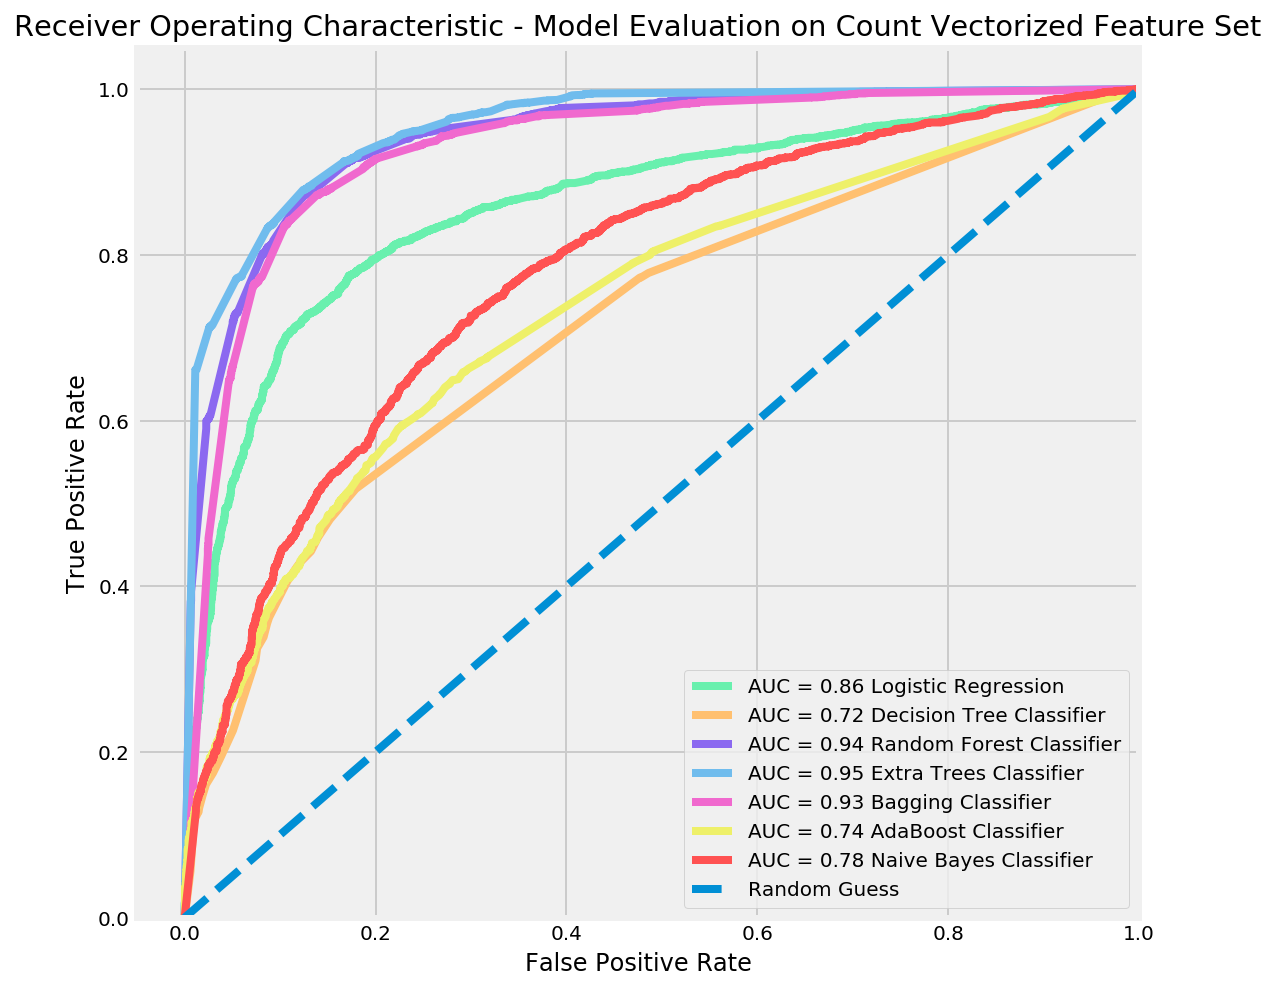

In [16]:
#Plot an ROC curve for each model on the same plot
fig, ax = plt.subplots(figsize=(8, 8))

plt.title(
    'Receiver Operating Characteristic - Model Evaluation on Count Vectorized Feature Set'
)

for i, model in enumerate(fit_models):
    probs = model.predict_proba(Xtest)
    preds = probs[:, 1]
    fpr, tpr, threshold = roc_curve(ytest, preds)
    roc_auc = auc(fpr, tpr)
    plt.plot(
        fpr,
        tpr,
        color=colours[i],
        label='AUC = %0.2f' % roc_auc + " " + model_names[i])

plt.plot([0, 1], [0, 1], '--', label="Random Guess")
plt.legend(loc='lower right')

plt.xlim([-0.05, 1.])

plt.ylim([0, 1.05])
ax.set_ylabel('True Positive Rate')
ax.set_xlabel('False Positive Rate')
plt.show()

### Evaluation of Count Vectorised feature set with Classifying Models

Looking at the AUC (Area Under the Curve), the best estimators are predicting at an aurea under the curve of between 0.78 and 0.95. The better performing models are the ensemble decision tree classifiers, with the best performing the Extra Trees Classifier.

The Extra Trees Classifier is similar to the Random Forest Classifer, however they have two differences in the way they operate. The Random Forest Classifer (RF) uses a boostrap method to build each decision tree in the ensemble (bagging) from a subset of the original data and then makes the decision to split at each node on the maximum information gain from a random subset of features. The Extra Trees Classifier (ET) does not use bagging, it uses the same data to train all trees, and then makes a split at each node on a random feature, with a random decision boundary.

We may see some difference between the two best performing models by looking at their precision recall curves

### Precision Recall Curves for the Models

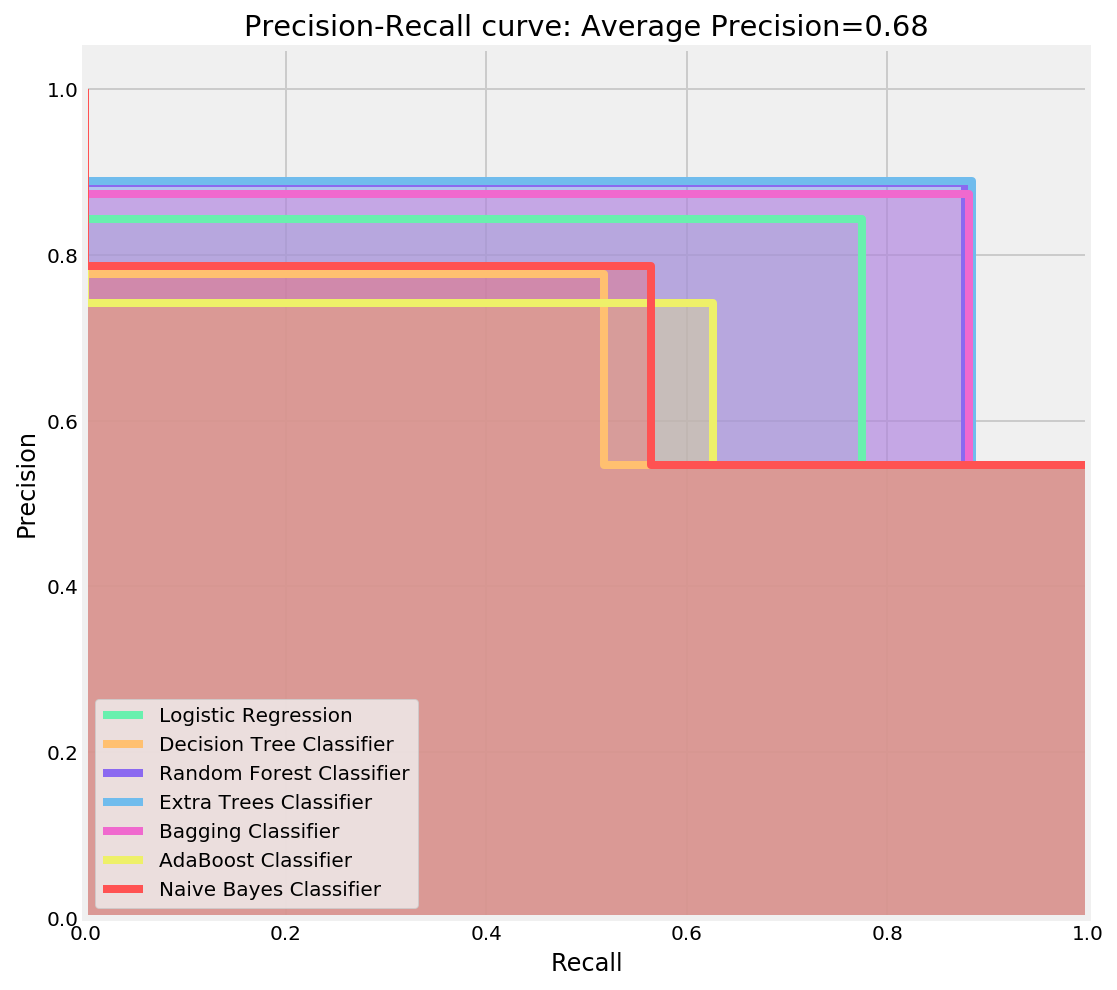

In [17]:
# Plot Multiple P-R curves
fig, ax = plt.subplots(figsize=(8, 8))
for i, model in enumerate(fit_models):
    precisions = []
    y_score = model.predict(Xtest)
    precision, recall, _ = precision_recall_curve(ytest, y_score)

    average_precision = average_precision_score(ytest, y_score)
    precisions.append(average_precision)

    plt.step(
        recall,
        precision,
        color=colours[i],
        alpha=1,
        where='post',
        label=model_names[i])
    plt.fill_between(
        recall, precision, step='post', alpha=0.3, color=colours[i])

    ax.set_xlabel('Recall')
    ax.set_ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.legend(loc='bottom left')

plt.title('Precision-Recall curve: Average Precision  all models) = {0:0.2f}'.format(
    np.mean(precisions)))
plt.show()

#### Gridsearching the Extra Trees Classifier

In [13]:
param_grid = {
    'n_estimators': [10,15,20],
    'max_features': ['auto', 'sqrt', 'log2']
}

CV_etc = GridSearchCV(ExtraTreesClassifier(), param_grid, verbose=1)

CV_etc.fit(Xtrain, ytrain)

Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=1)]: Done  27 out of  27 | elapsed:  7.6min finished


GridSearchCV(cv=None, error_score='raise',
       estimator=ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_estimators': [10, 15, 20], 'max_features': ['auto', 'sqrt', 'log2']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

In [20]:
CV_etc.best_score_

0.8471002654686542

In [21]:
CV_etc_model = CV_etc.best_estimator_

In [23]:
fit_models.append(CV_etc_model)

#### Gridsearching the Random Forest Classifier

In [22]:
param_grid = {
    'n_estimators': [10,15,20],
    'max_features': ['auto', 'sqrt', 'log2']
}

CV_rfc = GridSearchCV(RandomForestClassifier(), param_grid, verbose=1)

CV_rfc.fit(Xtrain, ytrain)

Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=1)]: Done  27 out of  27 | elapsed:  4.0min finished


GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_estimators': [10, 15, 20], 'max_features': ['auto', 'sqrt', 'log2']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

In [24]:
CV_rfc.best_score_

0.8440882172758832

This score looks much the same as the Extra Trees Model score

In [25]:
CV_rfc_model = CV_rfc.best_estimator_

In [26]:
fit_models.append(CV_rfc_model)

#### Looking at the ner ROC with the two gridsearched models
I'm hoping to see 2 new frontiers, towards the top left of the graph

In [27]:
# add the new model names to the list of names
model_names.extend(['Extra Trees Classifier - GS',
                    'Random Forest Classifer - GS'])

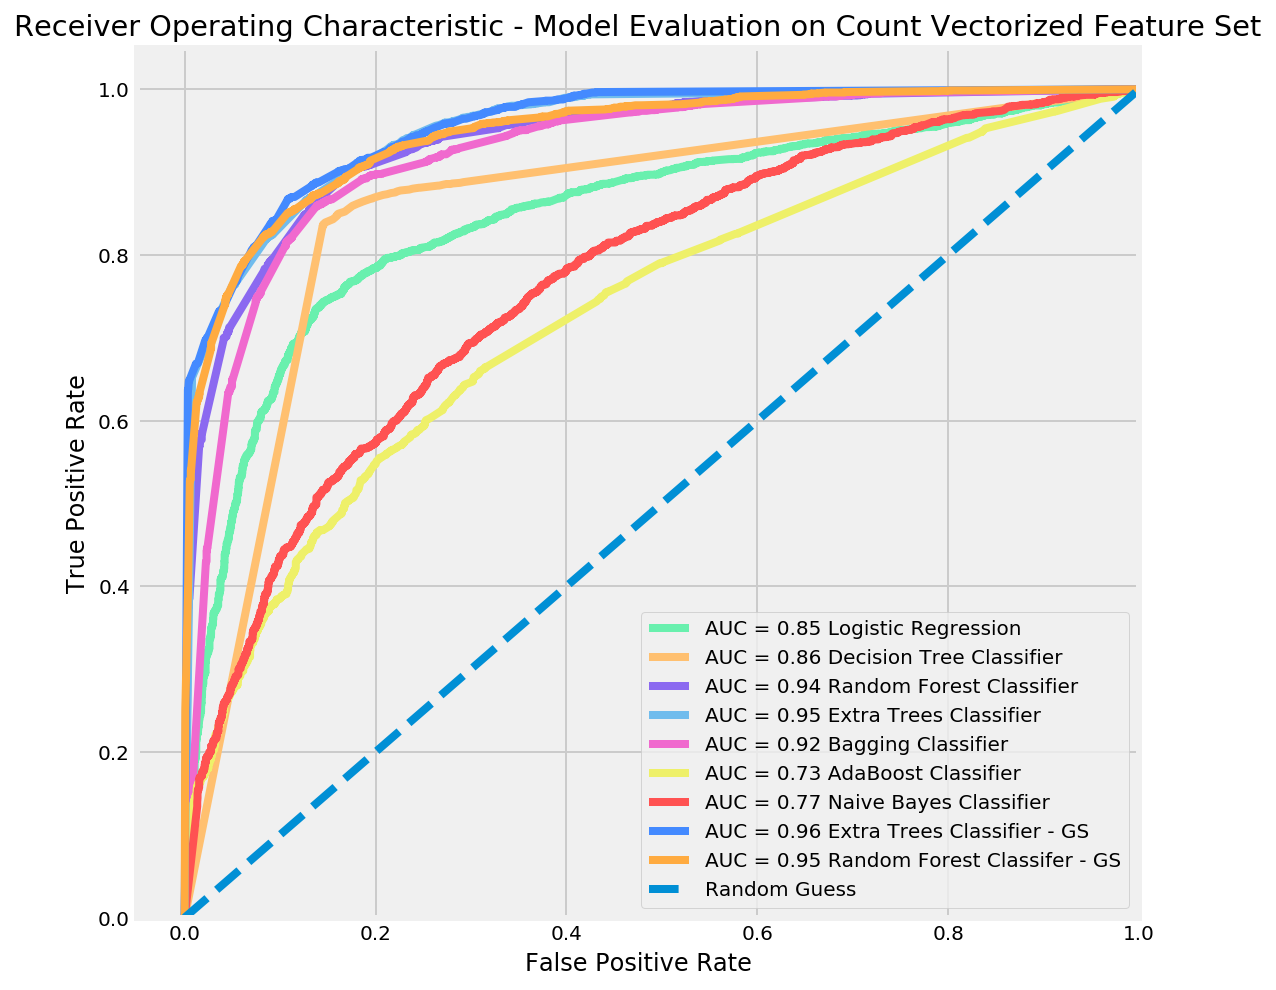

In [29]:
#Plot an ROC curve for each model on the same plot
fig, ax = plt.subplots(figsize=(8, 8))

plt.title(
    'Receiver Operating Characteristic - Model Evaluation on Count Vectorized Feature Set'
)

for i, model in enumerate(fit_models):
    probs = model.predict_proba(Xtest)
    preds = probs[:, 1]
    fpr, tpr, threshold = roc_curve(ytest, preds)
    roc_auc = auc(fpr, tpr)
    plt.plot(
        fpr,
        tpr,
        color=colours[i],
        label='AUC = %0.2f' % roc_auc + " " + model_names[i])

plt.plot([0, 1], [0, 1], '--', label="Random Guess")
plt.legend(loc='lower right')

plt.xlim([-0.05, 1.])

plt.ylim([0, 1.05])
ax.set_ylabel('True Positive Rate')
ax.set_xlabel('False Positive Rate')
plt.show()

The Area under the curve has increased one tenth for both models, showing a slight increase in accuracy, but the characteristics of the curve look much like the non gridsearched models.

### Addition of an extra feature

When doing my EDA, i looked at the length of reviews, by sentence count.

In [30]:
import re
df['sentences'] = df['comment'].map(lambda x: len(re.split(r'[.!?]+', x)))

#### Graph Showing the distributions of length by utility

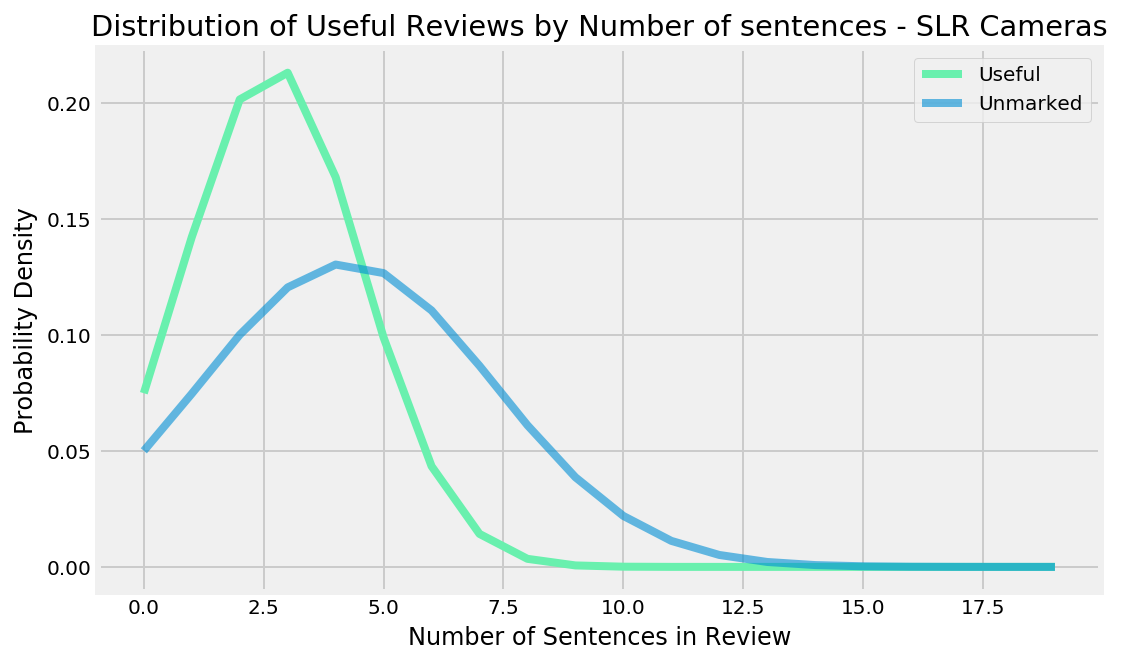

In [35]:
#establish mean and standard deviation of review length for useful reviews
mu = df.sentences[(df.category == "slr") & (df.useful == 1)].mean()
sigma = df.sentences[(df.category == "slr") & (df.useful == 1)].std()

#establish mean and standard deviation of review length for unmarked reviews
mu1 = df.sentences[(df.category == "slr") & (df.useful == 0)].mean()
sigma1 = df.sentences[(df.category == "slr") & (df.useful == 0)].std()

#set up the plot
fig, ax = plt.subplots(figsize=(8,5))
x = range(0,20)

y_pdf = ss.norm.pdf(x, mu, sigma) 
y_pdf2 = ss.norm.pdf(x, mu1, sigma1)

ax.set_xlabel("Number of Sentences in Review")
ax.set_ylabel("Probability Density")
ax.set_title("Distribution of Useful Reviews by Number of sentences - SLR Cameras")
plt.plot(x, y_pdf2, label='Useful',color="#69F0AE")
plt.plot(x, y_pdf, label='Unmarked',alpha=0.6)

plt.legend();

This graph clearly shows that the useful reviews tend to be shorter, I can run a t-test to determine if the average review lenght is indeed different across the classes

#### T-Test to Check Difference in Review Length is Not Down to Chance

In [36]:
t2, p2 = ss.ttest_ind(
    df.sentences[(df.category == "slr") & (df.useful == 1)],
    df.sentences[(df.category == "slr") & (df.useful == 0)],
    equal_var=False)
print("t stat = " + str(t2))
print("p value = " + str(2 * p2))  # 2 * for 2 tails

t stat = 50.262951846895106
p value = 0.0


the zero for p-value indicates that the mean review lengths are indeed different. This would suggest that there is signal in this indicator. I will add it as a feature to the end of the count vectorised words matrix.

By adding this feature, it will be important to re-scale my variables matrix, as now not everything will exist in the same units

#### Addition of sentence length and feature re-scale

In [39]:
# Add Sentence length to the 'words' matrix
words_sentences = words.join(df.sentences[df.category == "slr"])

In [45]:
#Rescale the words_sentences dataframe
ss = StandardScaler()
words_sen_ss = ss.fit_transform(words_sentences)
words_sen_ss = pd.DataFrame(words_sen_ss,columns = words_sentences.columns)

#### Fit models on training, test on testing data, and then review results

In [46]:
# Split the dataframe into train test sets
Xtrain_ss, Xtest_ss, ytrain_ss, ytest_ss = train_test_split(words_sen_ss.values, 
                                                            df.useful[df.category == "slr"].values,
                                                            test_size=0.25,
                                                            stratify=df.useful[df.category == "slr"].values)

In [49]:
#These models have no hyperparameter tuning at this stage
fit_models_sent = []
for i, model in enumerate(models):
    print(model)
    print()
    model.fit(Xtrain_ss, ytrain_ss)
    score = np.mean(cross_val_score(model,Xtest_ss,ytest_ss,cv=5))
    print(score)
    print("-" * 60)
    fit_models_sent.append(model)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

0.7068889076627999
------------------------------------------------------------
DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

0.7061230926327167
------------------------------------------------------------
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            m

#### Looking at the ROC for the new models

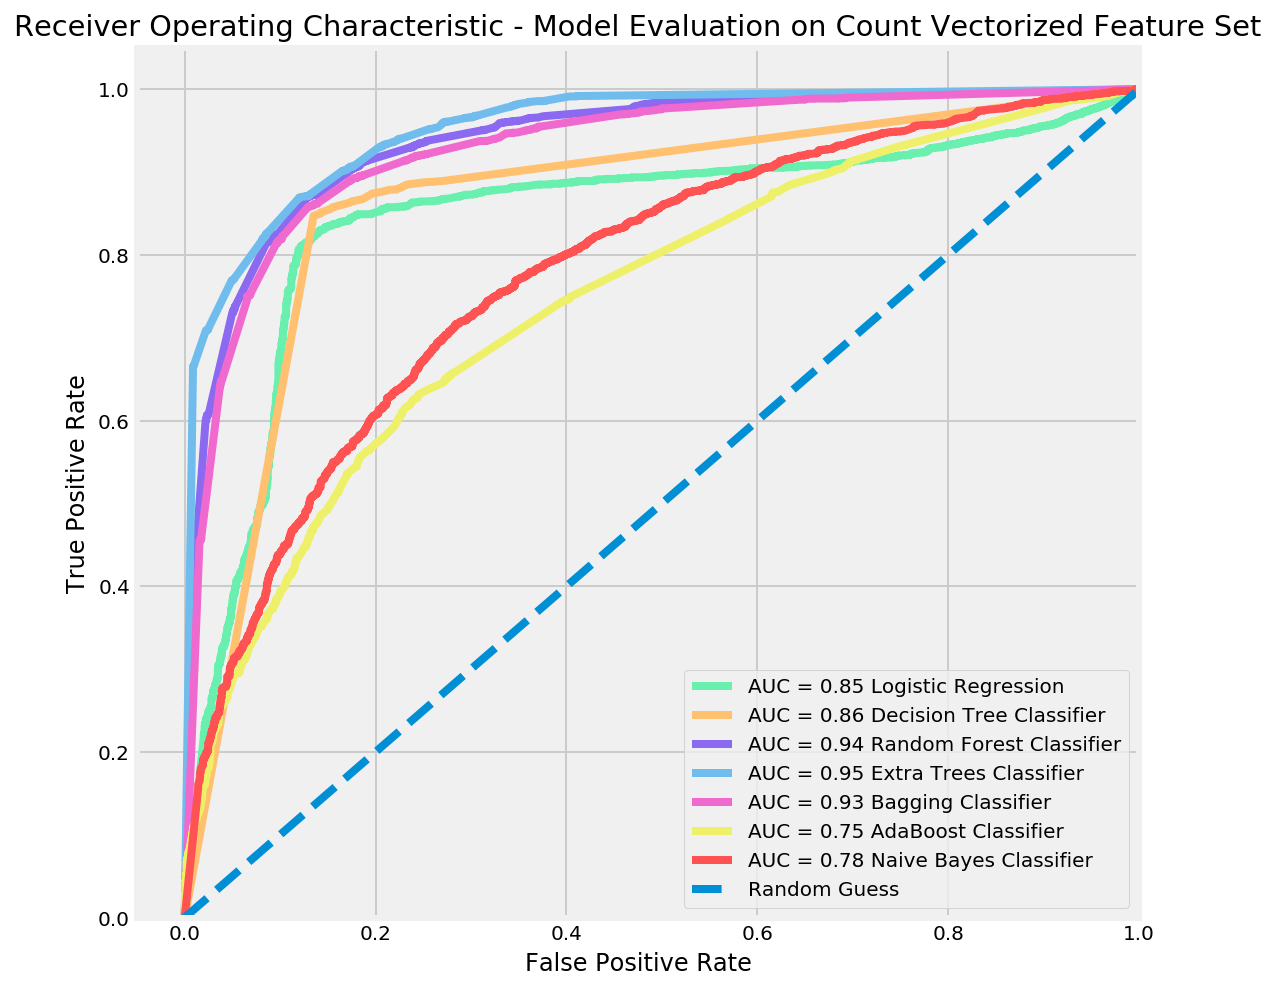

In [52]:
#Plot an ROC curve for each model on the same plot
fig, ax = plt.subplots(figsize=(8, 8))

plt.title(
    'Receiver Operating Characteristic - Model Evaluation on Count Vectorized Feature Set'
)

for i, model in enumerate(fit_models_sent):
    probs = model.predict_proba(Xtest_ss)
    preds = probs[:, 1]
    fpr, tpr, threshold = roc_curve(ytest_ss, preds)
    roc_auc = auc(fpr, tpr)
    plt.plot(
        fpr,
        tpr,
        color=colours[i],
        label='AUC = %0.2f' % roc_auc + " " + model_names[i])

plt.plot([0, 1], [0, 1], '--', label="Random Guess")
plt.legend(loc='lower right')

plt.xlim([-0.05, 1.])

plt.ylim([0, 1.05])
ax.set_ylabel('True Positive Rate')
ax.set_xlabel('False Positive Rate')
plt.show()

The addition of the sentence length does not look to have increased my model accuracy at all


## Looking at the TF-IDF for this set

With having a good lookig model so far, I wat to see if there are other ways to amplify the signal contained in this data. I wanted to look at term Frequency - Inverse Document Frequency. With count vectorised matrices of words, each word is considered as important as each other within the indiviual review, but with the inverse document frequency, we are able to reduce the importance of words that appear in multiple reviews, effectively filtering for the most 'important' words per review

In [5]:
df = pd.read_csv('master_data.csv')

In [18]:
# Establishing the tf-idf words matrix
tf = TfidfVectorizer(ngram_range=(1,4), max_features=5000, stop_words='english',
                     min_df=10)
tf_words = tf.fit_transform(df.comment[df.category == "slr"])

tf_words = pd.DataFrame(tf_words.todense(), columns=tf.get_feature_names())

#### Create Train -  Test Split for modelling

In [20]:
Xtrain_tf, Xtest_tf, ytrain_tf, ytest_tf = train_test_split(
    tf_words.values,
    df.useful[df.category == "slr"].values,
    test_size=0.25,
    stratify=df.useful[df.category == "slr"].values)

#### Use the classifying models to establish out of the box score

In [21]:
fit_models_tf = []
for i,model in enumerate(models):
    print(model)
    print()
    model.fit(Xtrain_tf, ytrain_tf)
    y_pred = model.predict(Xtest_tf)
    score = accuracy_score(ytest_tf, y_pred)
    print(score)
    print("-" * 60)
    fit_models_tf.append(model)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

0.762021439509954
------------------------------------------------------------
DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=10,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

0.6817764165390505
------------------------------------------------------------
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_

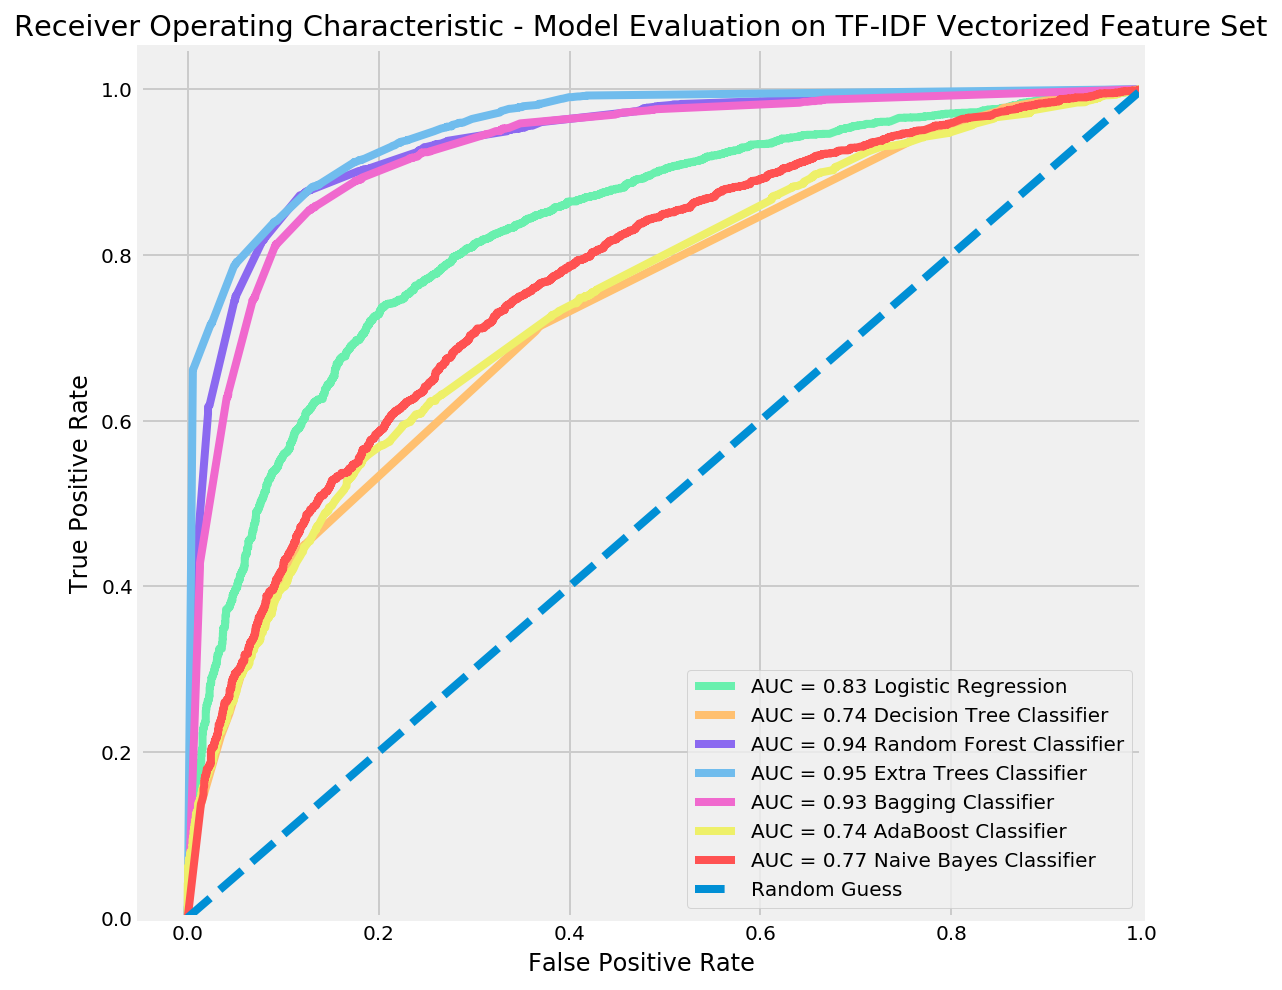

In [30]:
#Plot an ROC curve for each model on the same plot
fig, ax = plt.subplots(figsize=(8, 8))

plt.title(
    'Receiver Operating Characteristic - Model Evaluation on TF-IDF Vectorized Feature Set'
)

#iterate through the models fitted previously
for i, model in enumerate(fit_models_tf):
    probs = model.predict_proba(Xtest_tf)
    preds = probs[:, 1]
    fpr, tpr, threshold = roc_curve(ytest_tf, preds)
    roc_auc = auc(fpr, tpr)
    plt.plot(
        fpr,
        tpr,
        color=colours[i],  # use pre-defined colours
        label='AUC = %0.2f' % roc_auc + " " + model_names[i]
    )  #model names defined in list of strings - correspond by index to fitted models

plt.plot([0, 1], [0, 1], '--', label="Random Guess")
plt.legend(loc='lower right')

plt.xlim([-0.05, 1.])

plt.ylim([0, 1.05])
ax.set_ylabel('True Positive Rate')
ax.set_xlabel('False Positive Rate')
plt.show()

#### Looking at the classification report for the best count vectorized model vs the bset tf-idf model

In [31]:
# show classification report for the best tf-idf model
print(classification_report(ytest_tf,fit_models_tf[4].predict(Xtest_tf)))

             precision    recall  f1-score   support

          0       0.84      0.87      0.85      2963
          1       0.88      0.86      0.87      3567

avg / total       0.86      0.86      0.86      6530



In [35]:
# show classification report for the best count vectorised model
print(classification_report(ytest,fit_models[4].predict(Xtest)))

             precision    recall  f1-score   support

          0       0.58      0.53      0.55      2963
          1       0.64      0.68      0.66      3567

avg / total       0.61      0.61      0.61      6530



There looks to be little between the two models, looking at Area under the Curve. Looking at the classification reports, it is clear that one model outperforms the other. This can be seen more clearly in a Precision Recall Graph

#### Precision Recall Graph comparing Count Vectorised and TF-IDF matrices

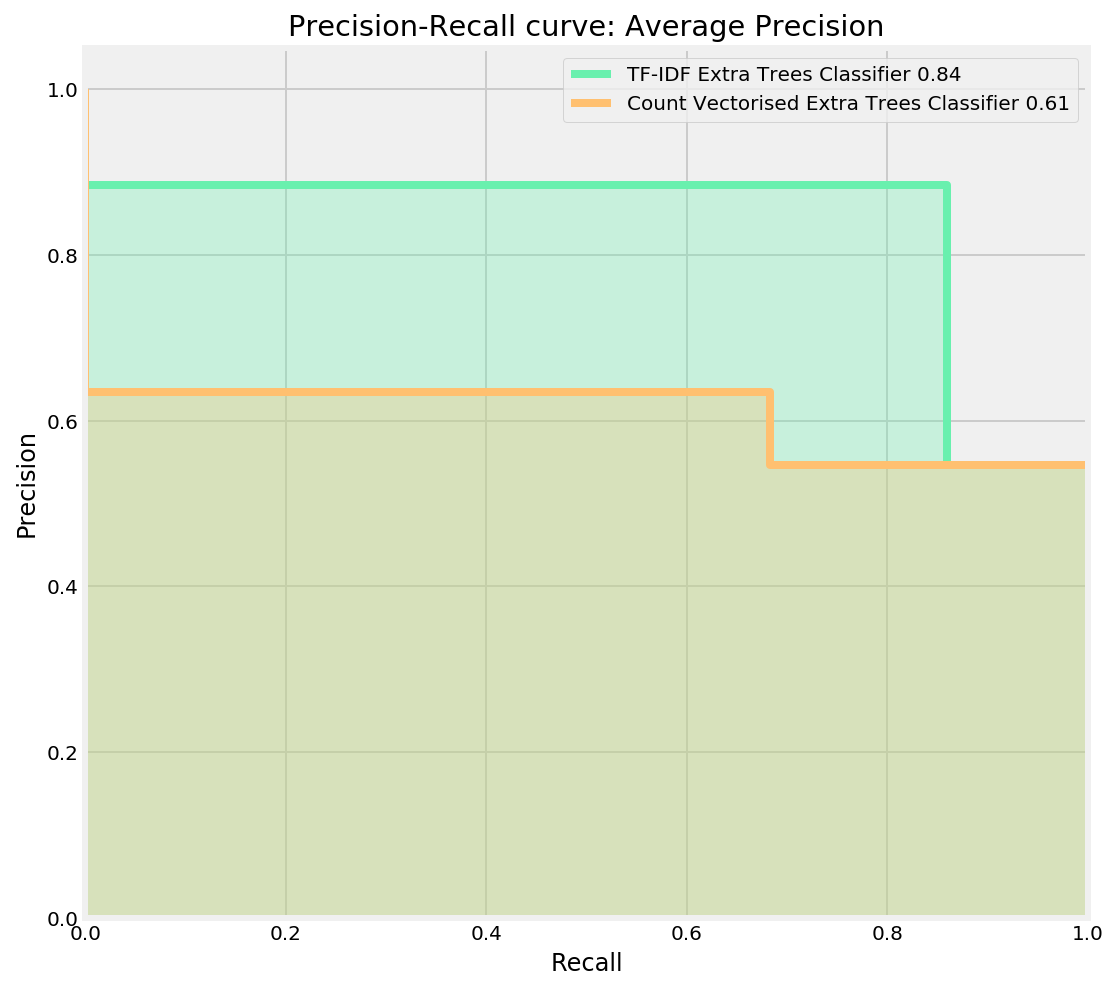

In [42]:
eval_models = [fit_models[4], fit_models_tf[4]]
eval_model_names = ['Count Vectorised Extra Trees Classifier', 'TF-IDF Extra Trees Classifier ']

fig, ax = plt.subplots(figsize=(8, 8))
#for tf-idf model
precisions = []
y_score = fit_models_tf[4].predict(Xtest_tf)
precision, recall, _ = precision_recall_curve(ytest_tf, y_score)

average_precision = average_precision_score(ytest_tf, y_score)
precisions.append(average_precision)

plt.step(
    recall,
    precision,
    color=colours[0],
    alpha=1,
    where='post',
    label='TF-IDF Extra Trees Classifier {0:0.2f}'.format(np.mean(precisions)))
plt.fill_between(
    recall, precision, step='post', alpha=0.3, color=colours[0])

#for Count Vectorised model
precisions = []
y_score = fit_models[4].predict(Xtest)
precision, recall, _ = precision_recall_curve(ytest, y_score)

average_precision = average_precision_score(ytest, y_score)
precisions.append(average_precision)

plt.step(
    recall,
    precision,
    color=colours[1],
    alpha=1,
    where='post',
    label='Count Vectorised Extra Trees Classifier {0:0.2f}'.format(np.mean(precisions)))
plt.fill_between(
    recall, precision, step='post', alpha=0.3, color=colours[1])



ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.legend(loc='bottom left')

plt.title('Precision-Recall curve: Average Precision')
plt.show()

I'm looking for a graph that extends to the top right, and clearly the TF-IDF matrix produces a model with the higher precision and recall

### Most Important Words to useful Reviews

The most important words to a 'useful' review will have the highest coefficient values in our model

In [22]:
#make a dataframe of all of our words, and their coefficient values from the model
important_words = pd.Series(fit_models_tf[3].feature_importances_, index=words.columns)

In [24]:
important_words.sort_values(ascending=False).head(20)

going strong          0.009352
got nikon             0.008304
came time             0.007653
camera work           0.004414
workhorse             0.004188
produces excellent    0.003741
love camera           0.003592
june                  0.003584
value price           0.003544
excellent buy         0.003431
photography camera    0.003297
died                  0.003125
hang                  0.003011
upgraded nikon        0.002983
bought body           0.002956
downside              0.002866
lens 18 55mm          0.002862
early                 0.002790
pushed                0.002786
camera worth penny    0.002716
dtype: float64

## Analysis of this model

With a TF-IDF feature matrix, and an Extra Trees Classifier, I was able to produce a model with 0.88 precision and 0.86 recall in establishing the utility of a review to other customers. 

## Create pipeline for best model

In [95]:
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('ETC', ExtraTreesClassifier()),
])
        
params = {
    
    'tfidf__ngram_range': [(1,4),(1,3)],
    'tfidf__max_features': [5000,2000,10000],
    'tfidf__stop_words':['english'],
    'ETC__n_estimators': [10,20,50]
    
}

In [96]:
grid_search = GridSearchCV(pipeline, params, verbose=1, cv=3)

### Fit the best model on the whole dataset

In [ ]:
grid_search.fit(df.comment[df.category == "slr"], df.useful[df.category == "slr"].values)

In [98]:
grid_search.best_score_

0.8433647293054598

In [99]:
grid_search.best_params_

{'ETC__n_estimators': 50,
 'tfidf__max_features': 10000,
 'tfidf__ngram_range': (1, 3),
 'tfidf__stop_words': 'english'}

In [100]:
best_model = grid_search.best_estimator_

In [102]:
best_model.predict_proba([''])

array([[0.62376238, 0.37623762]])

## Pickle the best model for use on Flask

In [103]:
import pickle
with open('model.pkl', 'wb') as f:
    pickle.dump(best_model, f)

## Visit the Predictor Site

http://www.ismyreviewuseful.com/ 

# Playmobil

## Trying with TF-IDF

In [145]:
# Establishing the tf-idf words matrix
tf = TfidfVectorizer(ngram_range=(1,4), max_features=5000, stop_words='english',
                     min_df=10)
tf_words = tf.fit_transform(df.comment[df.category == "playmobil"])

tf_words = pd.DataFrame(tf_words.todense(), columns=tf.get_feature_names())

In [146]:
Xtrain_tf, Xtest_tf, ytrain_tf, ytest_tf = train_test_split(
    tf_words.values,
    df.useful[df.category == "playmobil"].values,
    test_size=0.25,
    stratify=df.useful[df.category == "playmobil"].values)

In [195]:
models = [
    LogisticRegression(),
    DecisionTreeClassifier(max_depth=10),
    RandomForestClassifier(),
    ExtraTreesClassifier(),
    BaggingClassifier(),
    AdaBoostClassifier(),
    BernoulliNB()
]

In [148]:
fit_models_tf = []
for i,model in enumerate(models):
    print(model)
    print()
    model.fit(Xtrain_tf, ytrain_tf)
    y_pred = model.predict(Xtest_tf)
    score = accuracy_score(ytest_tf, y_pred)
    print(score)
    print("-" * 60)
    fit_models_tf.append(model)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

0.8184106436533621
------------------------------------------------------------
DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=10,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

0.8101402373247033
------------------------------------------------------------
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min

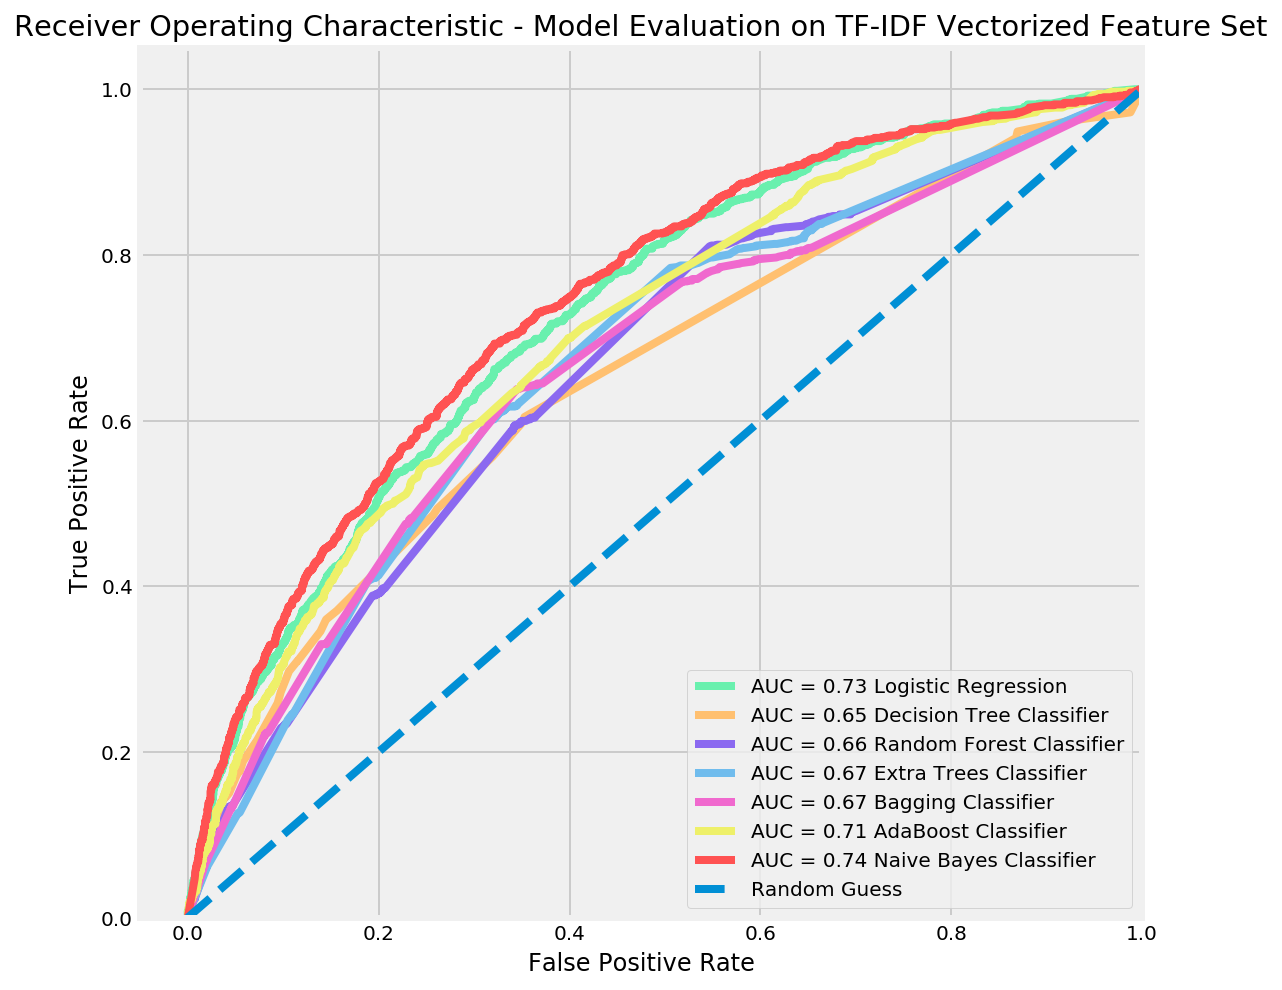

In [149]:
#Plot an ROC curve for each model on the same plot
fig, ax = plt.subplots(figsize=(8, 8))

plt.title(
    'Receiver Operating Characteristic - Model Evaluation on TF-IDF Vectorized Feature Set'
)

#iterate through the models fitted previously
for i, model in enumerate(fit_models_tf):
    probs = model.predict_proba(Xtest_tf)
    preds = probs[:, 1]
    fpr, tpr, threshold = roc_curve(ytest_tf, preds)
    roc_auc = auc(fpr, tpr)
    plt.plot(
        fpr,
        tpr,
        color=colours[i],  # use pre-defined colours
        label='AUC = %0.2f' % roc_auc + " " + model_names[i]
    )  #model names defined in list of strings - correspond by index to fitted models

plt.plot([0, 1], [0, 1], '--', label="Random Guess")
plt.legend(loc='lower right')

plt.xlim([-0.05, 1.])

plt.ylim([0, 1.05])
ax.set_ylabel('True Positive Rate')
ax.set_xlabel('False Positive Rate')
plt.show()

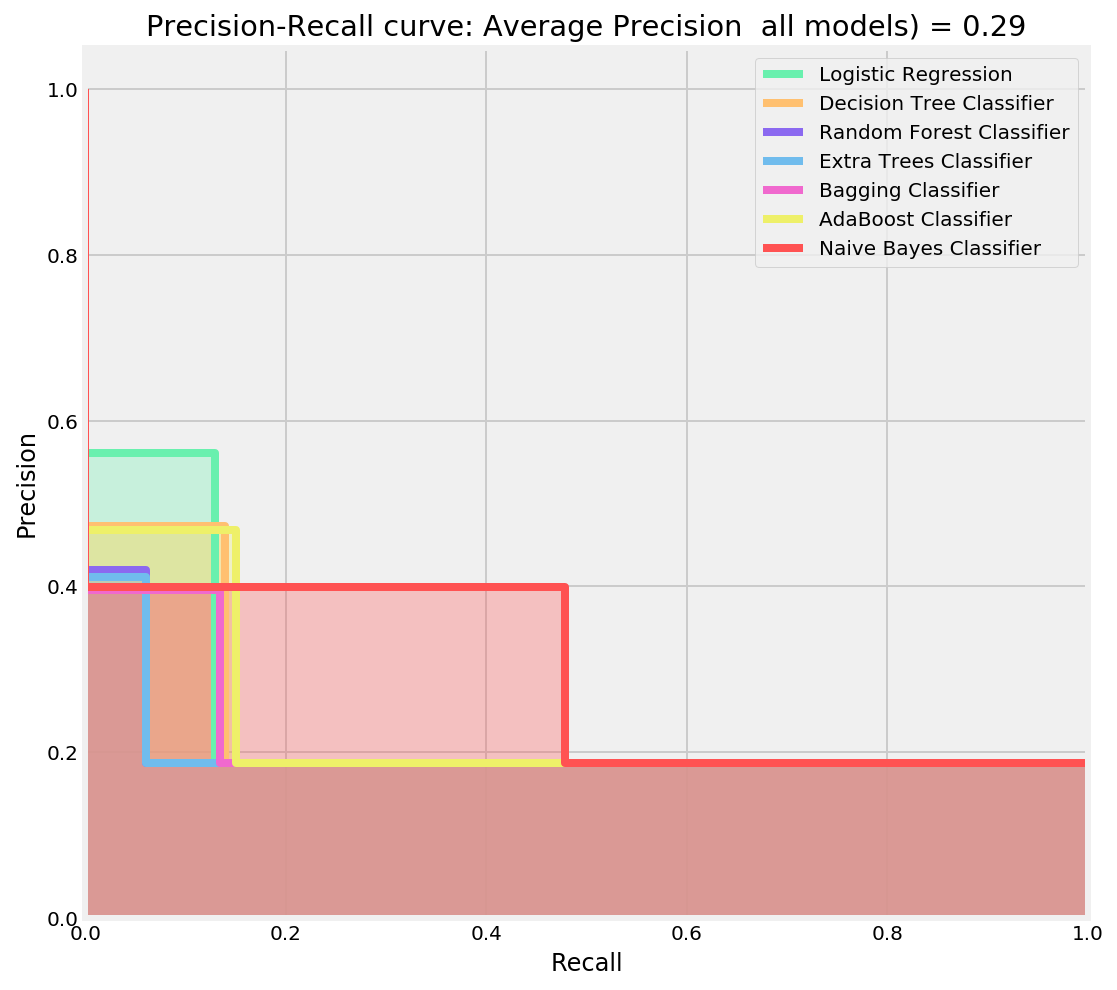

In [152]:
# Plot Multiple P-R curves
fig, ax = plt.subplots(figsize=(8, 8))
for i, model in enumerate(fit_models_tf):
    precisions = []
    y_score = model.predict(Xtest_tf)
    precision, recall, _ = precision_recall_curve(ytest_tf, y_score)

    average_precision = average_precision_score(ytest_tf, y_score)
    precisions.append(average_precision)

    plt.step(
        recall,
        precision,
        color=colours[i],
        alpha=1,
        where='post',
        label=model_names[i])
    plt.fill_between(
        recall, precision, step='post', alpha=0.3, color=colours[i])

    ax.set_xlabel('Recall')
    ax.set_ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.legend(loc='bottom left')

plt.title('Precision-Recall curve: Average Precision  all models) = {0:0.2f}'.format(
    np.mean(precisions)))
plt.show()

In [157]:
df.columns

Index(['asin', 'page', 'stars', 'author', 'date', 'title', 'comment',
       'verified', 'helpful', 'pics', 'video', 'comment_id', 'author_status',
       'category', 'topic', 'useful', 'comment_neg', 'comment_neu',
       'comment_pos', 'comment_compound'],
      dtype='object')

## Using Parts of Speech within only this category

In [165]:
df[[pos+'_prop' for pos in unique_pos]][df.category == "playmobil"].head()

,ADJ_prop,ADP_prop,ADV_prop,CCONJ_prop,DET_prop,INTJ_prop,NOUN_prop,NUM_prop,PART_prop,PRON_prop,PROPN_prop,PUNCT_prop,SPACE_prop,SYM_prop,VERB_prop,X_prop
136794,0.102564,0.025641,0.076923,0.051282,0.025641,0.0,0.102564,0.025641,0.025641,0.205128,0.025641,0.051282,0.0,0.0,0.282051,0.0
136795,0.100000,0.100000,0.000000,0.000000,0.100000,0.0,0.200000,0.100000,0.000000,0.100000,0.000000,0.100000,0.0,0.0,0.200000,0.0
136796,0.119048,0.071429,0.119048,0.000000,0.095238,0.0,0.166667,0.023810,0.023810,0.071429,0.047619,0.071429,0.0,0.0,0.190476,0.0
136797,0.038462,0.038462,0.115385,0.000000,0.076923,0.0,0.115385,0.000000,0.000000,0.076923,0.000000,0.307692,0.0,0.0,0.230769,0.0
136798,0.125000,0.041667,0.083333,0.000000,0.208333,0.0,0.166667,0.000000,0.000000,0.041667,0.000000,0.166667,0.0,0.0,0.166667,0.0


In [167]:
Xtrain_pos, Xtest_pos, ytrain_pos, ytest_pos = train_test_split(df[[pos+'_prop' for pos in unique_pos]][df.category == "playmobil"], df.useful[df.category == "playmobil"].values,
                                                                test_size=0.25,
                                                                stratify=df.useful[df.category == "playmobil"].values)

In [168]:
fit_models_pos = []
for i,model in enumerate(models):
    print(model)
    print()
    model.fit(Xtrain_pos, ytrain_pos)
    y_pred = model.predict(Xtest_pos)
    score = accuracy_score(ytest_pos, y_pred)
    print(score)
    print("-" * 60)
    fit_models_pos.append(model)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

0.8122977346278317
------------------------------------------------------------
DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=10,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

0.7928802588996764
------------------------------------------------------------
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min

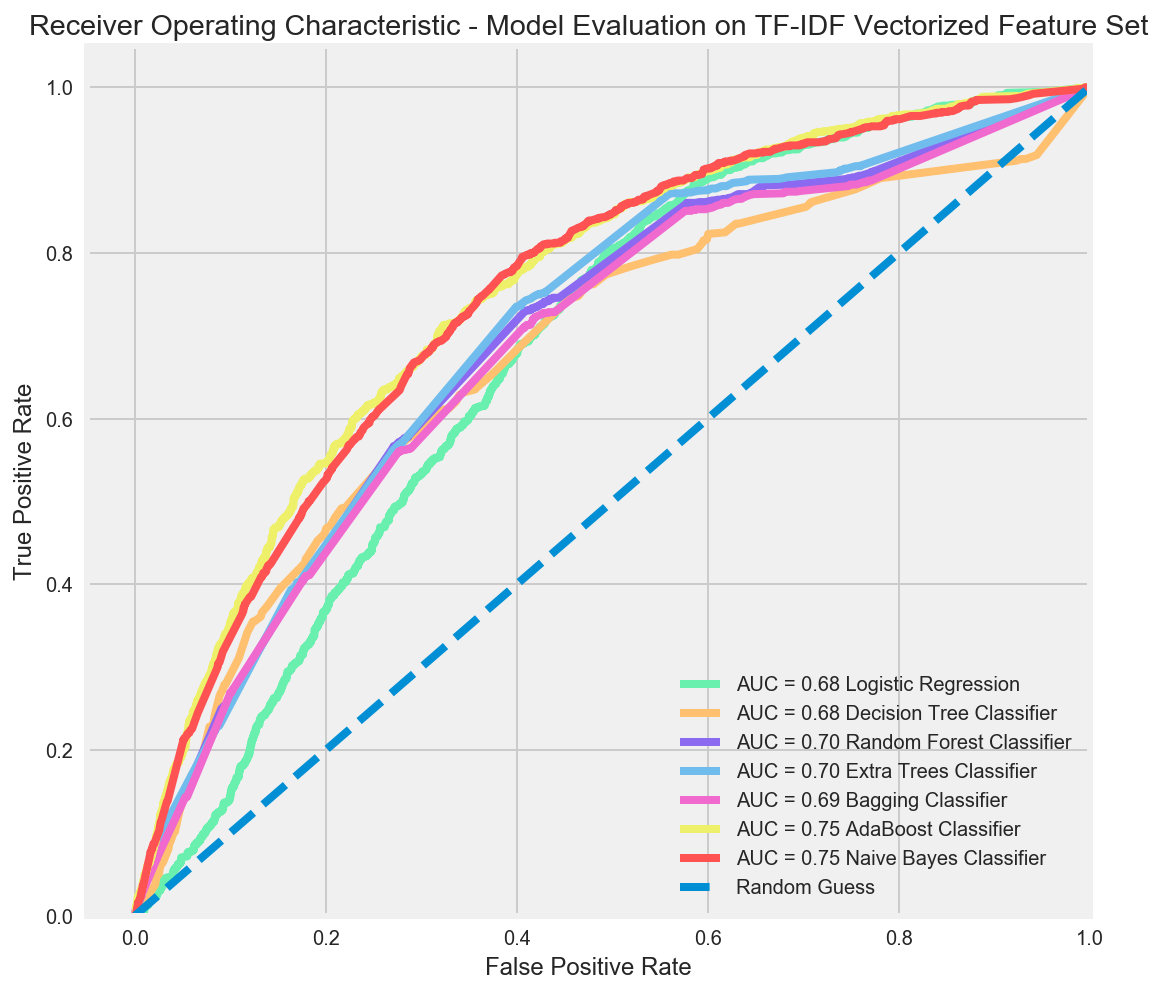

In [171]:
#Plot an ROC curve for each model on the same plot
fig, ax = plt.subplots(figsize=(8, 8))

plt.title(
    'Receiver Operating Characteristic - Model Evaluation on TF-IDF Vectorized Feature Set'
)

#iterate through the models fitted previously
for i, model in enumerate(fit_models_pos):
    probs = model.predict_proba(Xtest_pos)
    preds = probs[:, 1]
    fpr, tpr, threshold = roc_curve(ytest_pos, preds)
    roc_auc = auc(fpr, tpr)
    plt.plot(
        fpr,
        tpr,
        color=colours[i],  # use pre-defined colours
        label='AUC = %0.2f' % roc_auc + " " + model_names[i]
    )  #model names defined in list of strings - correspond by index to fitted models

plt.plot([0, 1], [0, 1], '--', label="Random Guess")
plt.legend(loc='lower right')

plt.xlim([-0.05, 1.])

plt.ylim([0, 1.05])
ax.set_ylabel('True Positive Rate')
ax.set_xlabel('False Positive Rate')
plt.show()

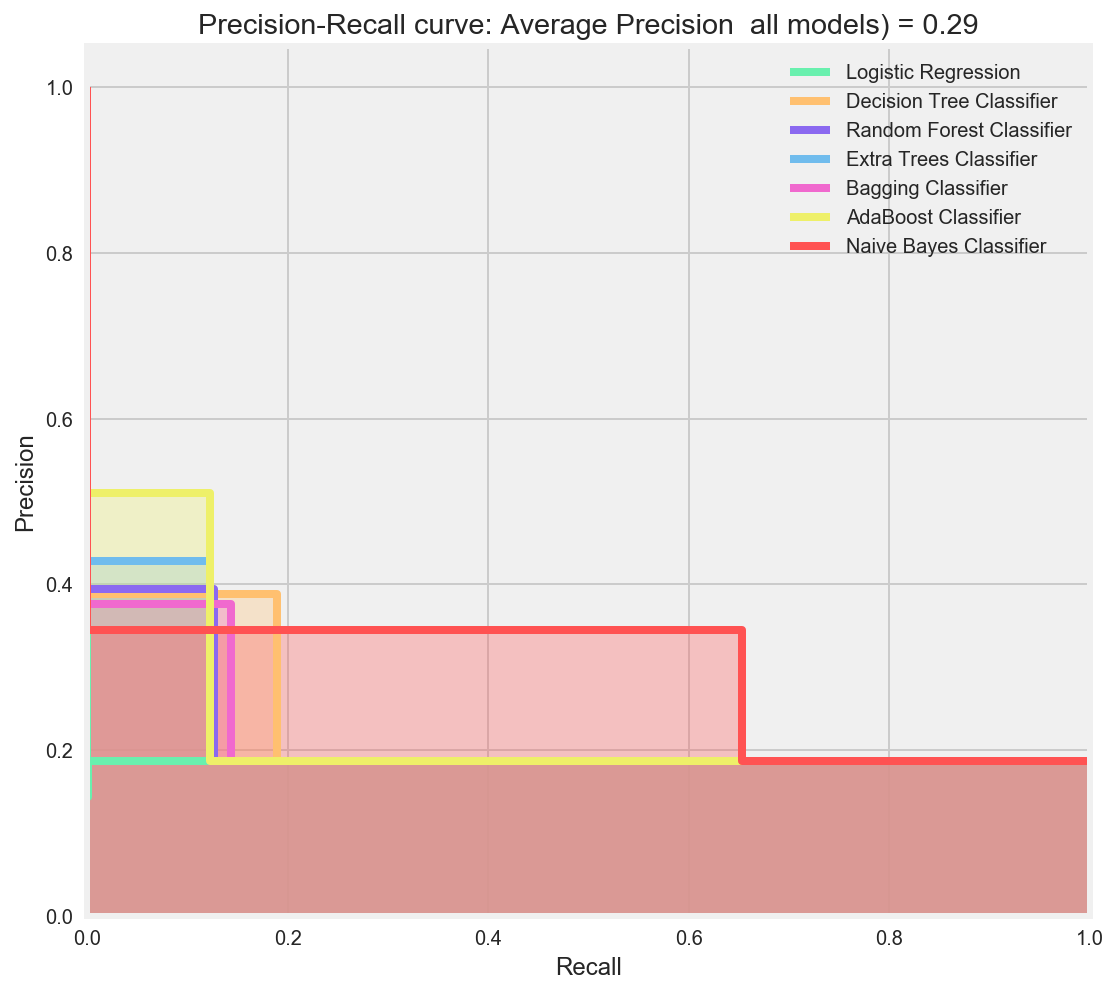

In [172]:
# Plot Multiple P-R curves
fig, ax = plt.subplots(figsize=(8, 8))
for i, model in enumerate(fit_models_pos):
    precisions = []
    y_score = model.predict(Xtest_pos)
    precision, recall, _ = precision_recall_curve(ytest_pos, y_score)

    average_precision = average_precision_score(ytest_pos, y_score)
    precisions.append(average_precision)

    plt.step(
        recall,
        precision,
        color=colours[i],
        alpha=1,
        where='post',
        label=model_names[i])
    plt.fill_between(
        recall, precision, step='post', alpha=0.3, color=colours[i])

    ax.set_xlabel('Recall')
    ax.set_ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.legend(loc='bottom left')

plt.title('Precision-Recall curve: Average Precision  all models) = {0:0.2f}'.format(
    np.mean(precisions)))
plt.show()

## Addition of Parts of speech to tf-idf

In [173]:
df[[pos+'_prop' for pos in unique_pos]].columns

Index(['ADJ_prop', 'ADP_prop', 'ADV_prop', 'CCONJ_prop', 'DET_prop',
       'INTJ_prop', 'NOUN_prop', 'NUM_prop', 'PART_prop', 'PRON_prop',
       'PROPN_prop', 'PUNCT_prop', 'SPACE_prop', 'SYM_prop', 'VERB_prop',
       'X_prop'],
      dtype='object')

In [178]:
pos_df = df[[pos+'_prop' for pos in unique_pos]][df.category == "playmobil"]

In [179]:
pos_df.reset_index(inplace=True)

In [182]:
pos_df.drop('index',axis=1, inplace=True)

In [186]:
joined_df = pos_df.join(tf_words)

In [187]:
ss = StandardScaler()

joined_df_ss = ss.fit_transform(joined_df)

In [193]:
joined_df_ss = pd.DataFrame(joined_df_ss, columns=joined_df.columns)

In [194]:
joined_df_ss.head()

,ADJ_prop,ADP_prop,ADV_prop,CCONJ_prop,DET_prop,INTJ_prop,NOUN_prop,NUM_prop,PART_prop,PRON_prop,...,yr,yr old,yr old boy,yr old daughter,yr old grandson,yr old loves,yr old son,yrs,zoo,zoo set
0,-0.445937,-0.711479,0.188181,0.617271,-0.543080,-0.096982,-0.749522,0.393571,0.385932,1.908080,...,-0.08932,-0.085778,-0.020511,-0.023623,-0.033367,-0.031544,-0.0332,-0.030079,-0.070988,-0.024551
1,-0.458522,0.246149,-0.754289,-0.707511,0.473809,-0.096982,-0.022735,2.595441,-0.512097,0.540421,...,-0.08932,-0.085778,-0.020511,-0.023623,-0.033367,-0.031544,-0.0332,-0.030079,-0.070988,-0.024551
2,-0.365037,-0.121807,0.704296,-0.707511,0.408688,-0.096982,-0.271373,0.339337,0.321787,0.168723,...,-0.08932,-0.085778,-0.020511,-0.023623,-0.033367,-0.031544,-0.0332,-0.030079,-0.070988,-0.024551
3,-0.760547,-0.546371,0.659416,-0.707511,0.158223,-0.096982,-0.653892,-0.365695,-0.512097,0.240203,...,-0.08932,-0.085778,-0.020511,-0.023623,-0.033367,-0.031544,-0.0332,-0.030079,-0.070988,-0.024551
4,-0.335824,-0.505094,0.266720,-0.707511,1.955310,-0.096982,-0.271373,-0.365695,-0.512097,-0.218463,...,-0.08932,-0.085778,-0.020511,-0.023623,-0.033367,-0.031544,-0.0332,-0.030079,-0.070988,-0.024551


In [196]:
Xtrain_ss, Xtest_ss, ytrain_ss, ytest_ss = train_test_split(
    joined_df_ss.values,
    df.useful[df.category == "playmobil"].values,
    test_size=0.25,
    stratify=df.useful[df.category == "playmobil"].values)

In [199]:
fit_models_ss = []
for i,model in enumerate(models):
    print(model)
    print()
    model.fit(Xtrain_ss, ytrain_ss)
    y_pred = model.predict(Xtest_ss)
    score = accuracy_score(ytest_ss, y_pred)
    print(score)
    print("-" * 60)
    fit_models_ss.append(model)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

0.7527867673498742
------------------------------------------------------------
DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=10,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

0.7988133764832794
------------------------------------------------------------
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min

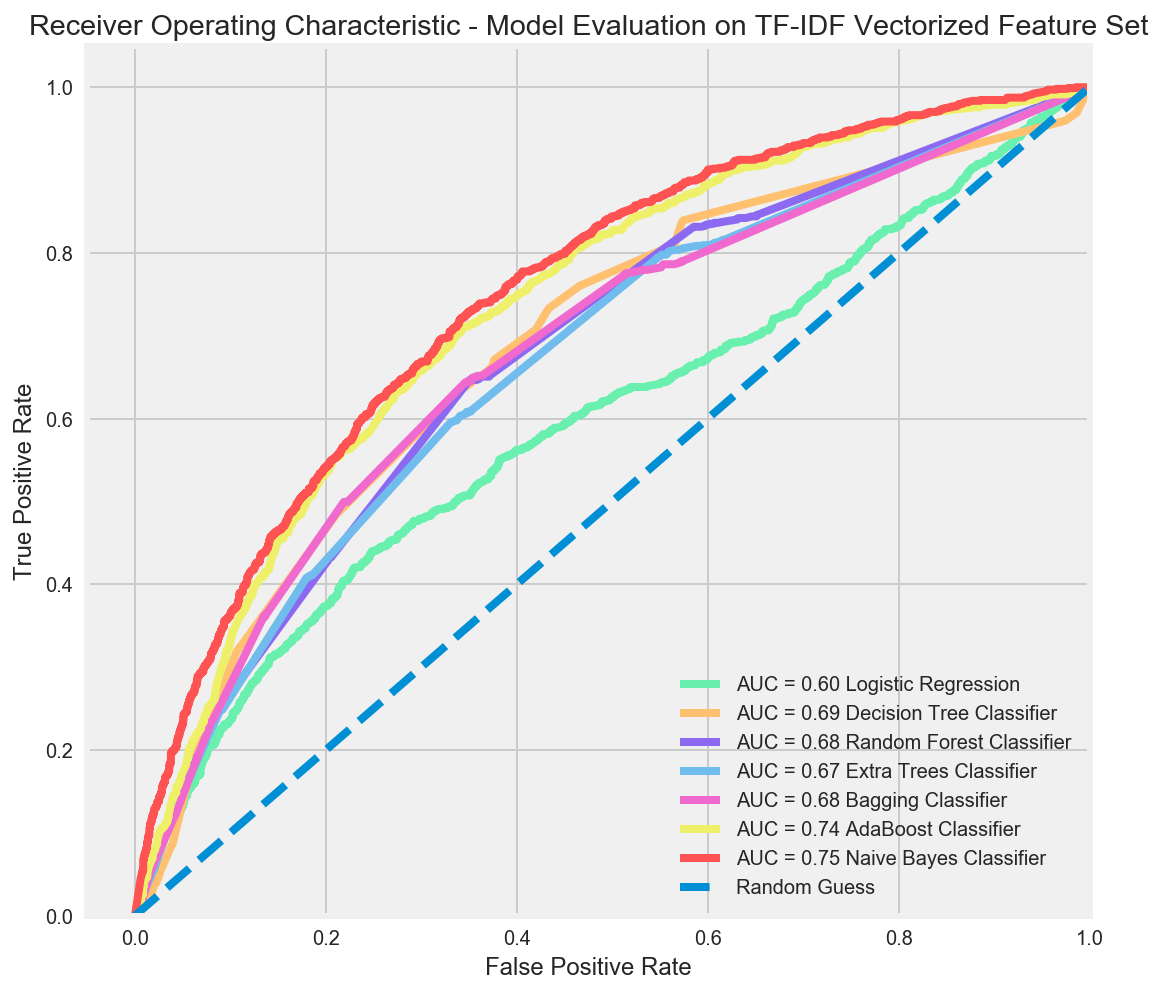

In [200]:
#Plot an ROC curve for each model on the same plot
fig, ax = plt.subplots(figsize=(8, 8))

plt.title(
    'Receiver Operating Characteristic - Model Evaluation on TF-IDF Vectorized Feature Set'
)

#iterate through the models fitted previously
for i, model in enumerate(fit_models_ss):
    probs = model.predict_proba(Xtest_ss)
    preds = probs[:, 1]
    fpr, tpr, threshold = roc_curve(ytest_ss, preds)
    roc_auc = auc(fpr, tpr)
    plt.plot(
        fpr,
        tpr,
        color=colours[i],  # use pre-defined colours
        label='AUC = %0.2f' % roc_auc + " " + model_names[i]
    )  #model names defined in list of strings - correspond by index to fitted models

plt.plot([0, 1], [0, 1], '--', label="Random Guess")
plt.legend(loc='lower right')

plt.xlim([-0.05, 1.])

plt.ylim([0, 1.05])
ax.set_ylabel('True Positive Rate')
ax.set_xlabel('False Positive Rate')
plt.show()

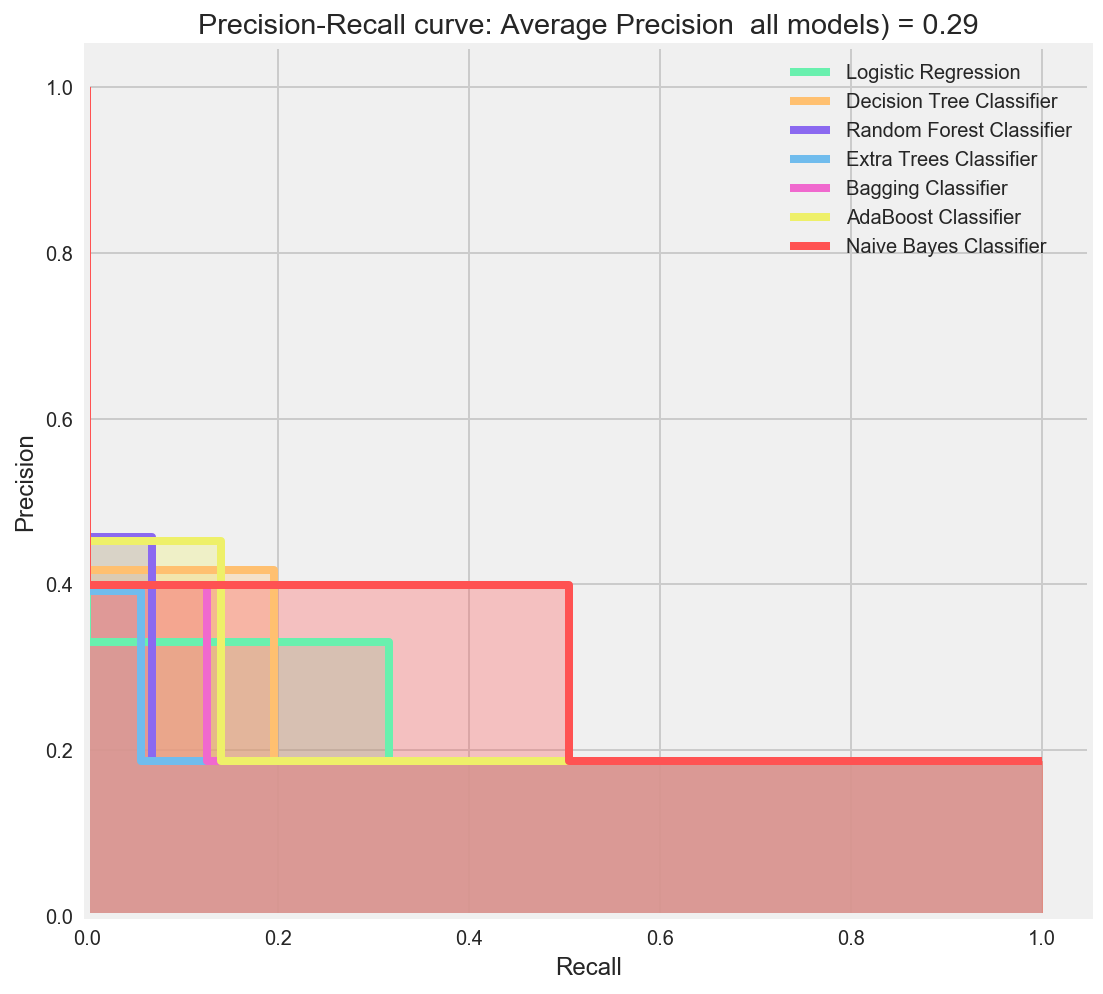

In [202]:
# Plot Multiple P-R curves
fig, ax = plt.subplots(figsize=(8, 8))
for i, model in enumerate(fit_models_ss):
    precisions = []
    y_score = model.predict(Xtest_ss)
    precision, recall, _ = precision_recall_curve(ytest_ss, y_score)

    average_precision = average_precision_score(ytest_ss, y_score)
    precisions.append(average_precision)

    plt.step(
        recall,
        precision,
        color=colours[i],
        alpha=1,
        where='post',
        label=model_names[i])
    plt.fill_between(
        recall, precision, step='post', alpha=0.3, color=colours[i])

    ax.set_xlabel('Recall')
    ax.set_ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.05])
    plt.legend(loc='bottom left')

plt.title('Precision-Recall curve: Average Precision  all models) = {0:0.2f}'.format(
    np.mean(precisions)))
plt.show()

## Using a count vectorizer to establish cosine similarity between reviews

In [204]:
cv = CountVectorizer(ngram_range=(1,4),max_features=10000,min_df = 10)

cv_words = cv.fit_transform(df.comment[df.category == "playmobil"])

In [205]:
from sklearn.metrics.pairwise import cosine_similarity

In [206]:
cos = cosine_similarity(cv_words,cv_words)

In [209]:
cos_df = pd.DataFrame(cos)

In [244]:
cos_df.head(50)

,0,1,2,3,4,5,6,7,8,9,...,22235,22236,22237,22238,22239,22240,22241,22242,22243,22244
0,1.000000,0.137464,0.209980,0.087727,0.062994,0.297670,0.176006,0.041996,0.102869,0.058321,...,0.325112,0.062994,0.187975,0.036370,0.125988,0.216748,0.128388,0.300329,0.241139,0.047619
1,0.137464,1.000000,0.096986,0.075974,0.036370,0.220963,0.055427,0.000000,0.148478,0.101015,...,0.187703,0.000000,0.000000,0.000000,0.109109,0.071508,0.049417,0.053812,0.108283,0.000000
2,0.209980,0.096986,1.000000,0.154736,0.111111,0.112509,0.127000,0.111111,0.151203,0.188593,...,0.149334,0.055556,0.103612,0.032075,0.000000,0.100128,0.062904,0.127866,0.118147,0.083992
3,0.087727,0.075974,0.154736,1.000000,0.087039,0.156682,0.088432,0.116052,0.094756,0.188025,...,0.149736,0.043519,0.032466,0.050252,0.174078,0.057044,0.019710,0.100164,0.259141,0.000000
4,0.062994,0.036370,0.111111,0.087039,1.000000,0.075006,0.169334,0.055556,0.158763,0.282889,...,0.304642,0.083333,0.326377,0.144338,0.000000,0.232116,0.132099,0.136999,0.189035,0.000000
5,0.297670,0.220963,0.112509,0.156682,0.075006,1.000000,0.200041,0.000000,0.199037,0.104163,...,0.393153,0.084382,0.188847,0.032478,0.168763,0.248861,0.152869,0.305189,0.311046,0.000000
6,0.176006,0.055427,0.127000,0.088432,0.169334,0.200041,1.000000,0.127000,0.120978,0.117579,...,0.218482,0.063500,0.213171,0.073324,0.000000,0.166468,0.143799,0.167030,0.171053,0.000000
7,0.041996,0.000000,0.111111,0.116052,0.055556,0.000000,0.127000,1.000000,0.045361,0.051434,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.082199,0.047259,0.000000
8,0.102869,0.148478,0.151203,0.094756,0.158763,0.199037,0.120978,0.045361,1.000000,0.167984,...,0.278002,0.068041,0.177657,0.078567,0.068041,0.133780,0.107858,0.212533,0.173640,0.000000
9,0.058321,0.101015,0.188593,0.188025,0.282889,0.104163,0.117579,0.051434,0.167984,1.000000,...,0.223976,0.115728,0.201444,0.133631,0.000000,0.151692,0.104828,0.139520,0.164074,0.000000


In [213]:
play = df[df.category == "playmobil"]

In [214]:
play.reset_index(inplace=True)

In [243]:
play.loc[3,'comment']

'Very cross!!!! This arrived with no outer box, so daughter saw what it was when it was delivered!!!'

In [241]:
play.loc[22243,'comment']

'I am now much older, but me and my brother had this toy when we were little, it was introduced when wheely bins came out as "new technology" and we were fascinated by the new trucks. It is the best toy we ever had, just because you can guarantee no one else will have it and it is just so odd. You should definately buy it for any child as it is fascinating and a toy they won\'t forget.'

In [238]:
play.loc[22243,'useful']

1

In [239]:
play.loc[3,'useful']

1

In [245]:
cos_df.to_csv('play_cosine.csv')